# World Data League 2023

## 🎯 Challenge
### **Energy communities inclusive of residents vulnerable to energy poverty** in the City of Ghent


## Team: Data Warriors
## 👥 Authors
* Clara Pedroso
* Gonçalo Ferreira
* João Anacleto
* Madalena Diniz

## 💻 Development

### Introduction

The City of Ghent in Belgium is actively working towards **climate mitigation and adaptation**. With a strong focus on participation and behavioral change, the city has implemented successful initiatives in **energy renovation, sustainable food, and mobility**.
> Ghent promotes the Sustainable Development Goals, particularly SDG7, and aims to **establish energy communities to ensure equitable energy distribution**.

By **leveraging data on energy consumption, vulnerability, and green energy potential**, the city plans to engage citizens and foster local renewable energy production. This challenge will guide decision-making processes and support cooperative entities with citizens as active participants in the energy transition.



---


For this, we will follow these steps:

0. Data Importation: import all libraries needed and datasets for this challenge;
1. Pre Processing: check if there are any inconsistencies in the datasets and treat them;
2. Datasets Merge: merge all datasets into one that will be used for the model;
3. Feature Selection: check which variables are influencing the model and which ones are not;
4. Model Training: train a model to predict the target variable.

#### Variables Dictionary


We decided to add a little explanation of all the variables we took to the feature selection part:

**Weather**:
- **Temperature**, the mean temperature at 2m elevation during that day (ºC)
- **Precipitation**, the total prpecipitation of the day (mm)
- **Cloud Cover**, is the daily total percentage of the sky that is covered by clouds (%)
- **Longwave radiation**, the daily radiation emitted by the Earth's surface and atmosphere (W/m2)
-**UV radiation**, the daily solar radiation that can penetrate into the water column and affect the physiology of marine organisms  (W/m2)

**Ocean Conditions**
- **Avg fCO2**, the average fCO2 (partial pressure of carbon dioxide) across all observations, indicating the overall carbon dioxide concentration in the studied area, which directly affects the pH of seawater and overall health of marine ecosystems, measured in microatmospheres (uatm)
-**Avg SST**, the average sea surface temperature across all observations, provides an indication of the typical temperature conditions experienced at the ocean's surface (ºC)
-**Avg Salinity**, the average salinity across all observations, indicating the typical salt concentration in the study area, which helps assess the suitability of the environment for different marine species, measured in practical salinity units (PSU)

**Disposals in Water**
- **Index of Coastal Eutrophication**, associated with the SDG14.1, this measures the level of excessive nutrient enrichment in coastal waters, which is an indicator of the ecological health and potential degradation of coastal areas
- **Air Pollutant Compliance**, the degree to which the concentration of the worst air pollutant in Cascais complies with the legal limits. it provides an assessment of air quality and the extent of adherence to regulatory standards (%)
- **Pollutants in Water**, cumulative amount of pollutants discharged into the water per year, includes various contaminants such as chemicals, toxins, and other harmful substances (kg/year)
- **Waste in Water**, the overall quantity of waste disposed into the water per year, includes solid waste, sewage, and other forms of waste that are released into aquatic environments (t/year)

### 0. Data Importation

####0.1 Importing Libraries and packages

In [389]:
!pip install geopandas
!pip install rtree

import os
import re
import json
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import xgboost as xgb
from rtree import Index
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_score
from sklearn.base import clone
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


####0.2 Importing Datasets

Definition of a working directory to Google drive and impoting the datasets

In [390]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


The data provided was separated in:
* **Geographical data on sun irradiation** on a 3D model of Ghent


In [391]:
path_to_folder = "/content/drive/MyDrive/Colab Notebooks/WDL Finals/data/pv_data"

data_pv = gpd.read_file(path_to_folder)

data_pv.head()

# We will only use Gent_SOL_v3 since it is the officially published version

,GRB_UIDN,GRB_OIDN,ENTITEIT,TYPE,LBLTYPE,DATUM_GRB,DATUM_LID,OPPERVL,LENGTE,STRAATNMID,STRAATNM,NISCODE,GEMEENTE,POSTCODE,HNRLABEL,SLO_OPP,SLO_OPP_3D,SLOPE,ASPECT,geometry
0,149248,109594,Gbg,1,hoofdgebouw,2003-10-16,2013-04-08,296.97,107.28,69676,Begoniastraat,44021,Gent,9052,5-15,78,78,6,252,"POLYGON ((103665.000 187986.000, 103665.000 18..."
1,149248,109594,Gbg,1,hoofdgebouw,2003-10-16,2013-04-08,296.97,107.28,69676,Begoniastraat,44021,Gent,9052,5-15,146,146,1,-9999,"POLYGON ((103651.500 187989.000, 103651.500 18..."
2,156401,116747,Gbg,1,hoofdgebouw,2003-10-16,2013-04-08,385.93,98.09,0,NaN,NaN,NaN,0,NaN,167,167,1,-9999,"POLYGON ((104261.500 187559.000, 104261.500 18..."
3,156401,116747,Gbg,1,hoofdgebouw,2003-10-16,2013-04-08,385.93,98.09,0,NaN,NaN,NaN,0,NaN,136,136,1,198,"POLYGON ((104248.500 187569.500, 104248.500 18..."
4,140442,100788,Gbg,1,hoofdgebouw,2003-10-16,2013-04-08,121.68,59.73,70254,Grotesteenweg-Zuid,44021,Gent,9052,23,9,9,8,-9999,"POLYGON ((102319.000 187873.000, 102319.000 18..."


* 3 Datasets from the Fluvius energy company on **energy consumption** in Ghent.

In [392]:
data_se = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WDL Finals/data/energy_consumption_sectors.csv', delimiter=';')
data_st = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WDL Finals/data/energy_consumption_street_level.csv', delimiter=';')
data_m = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WDL Finals/data/energy_consumption_monthly.csv', delimiter=';')

* 4 Datasets from Fluvius on **energy production, storage devices and EV charging points**.

In [393]:
data_loc = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WDL Finals/data/energy_local_production.csv', delimiter=';')
data_dc = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WDL Finals/data/energy_decentral_production.csv', delimiter=';')
data_sto = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WDL Finals/data/energy_storage_systems.csv', delimiter=';')
data_e = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WDL Finals/data/ev_points.csv', delimiter=';')

In [394]:
data_e.head()

,Jaartal indienstname,Postcode,Vermogen (kVA),Spanningsniveau aansluiting,Postcode (hiërarchisch),Uniek_order_ID,geom,centroid,Postcode Numeriek
0,2017,3840,22.20,LS,3xxx-38xx-384x-3840,1,"{""coordinates"": [[[[5.372256859, 50.842703966]...","50.804781683,5.340930556",3840
1,2017,3700,22.20,LS,3xxx-37xx-370x-3700,5,"{""coordinates"": [[[[5.416280501, 50.722817984]...","50.771788367,5.464431132",3700
2,2017,8600,22.20,LS,8xxx-86xx-860x-8600,9,"{""coordinates"": [[[[2.770542675, 51.017105977]...","51.047386295,2.854235412",8600
3,2017,3770,22.20,LS,3xxx-37xx-377x-3770,10,"{""coordinates"": [[[[5.614790217, 50.838689041]...","50.805367608,5.592306546",3770
4,2017,8820,22.20,LS,8xxx-88xx-882x-8820,11,"{""coordinates"": [[[[3.043475238, 51.060621091]...","51.062335749,3.095486083",8820


* A dataset from Ghent in cijfers on **average income per sector**.

In [395]:
data_inc = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WDL Finals/data/average_income_per_sector.csv', delimiter=';')

* A dataset on **current rent prices** in different locations in Ghent.

In [396]:
data_r = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WDL Finals/data/ghent_rent_prices.csv', delimiter=',')

* An external geodataset on **Gent grid** that divides the city of Gent into various polygons.

In [397]:
path_to_folder = "/content/drive/MyDrive/Colab Notebooks/WDL Finals/data/Geodata.be"

gent_shapefile = gpd.read_file(path_to_folder)

gent_shapefile.head()

,COUNTRY,CITIES,FUA_OR_CIT,CODE2012,ITEM2012,PROD_DATE,IDENT,Shape_Leng,Shape_Area,geometry
0,BE,Gent,BE003L2,11100,Continuous urban fabric (S.L. : > 80%),2016,1-BE003L2,230.59,2806.60,"POLYGON ((3886195.870 3106467.186, 3886168.088..."
1,BE,Gent,BE003L2,11100,Continuous urban fabric (S.L. : > 80%),2016,2-BE003L2,306.51,4761.27,"POLYGON ((3875218.530 3107115.707, 3875218.144..."
2,BE,Gent,BE003L2,11100,Continuous urban fabric (S.L. : > 80%),2016,3-BE003L2,528.42,11971.34,"POLYGON ((3875659.918 3107304.550, 3875660.469..."
3,BE,Gent,BE003L2,11100,Continuous urban fabric (S.L. : > 80%),2016,4-BE003L2,205.01,2572.65,"POLYGON ((3886148.230 3107348.991, 3886129.724..."
4,BE,Gent,BE003L2,11100,Continuous urban fabric (S.L. : > 80%),2016,5-BE003L2,228.44,2786.24,"POLYGON ((3886156.182 3107427.625, 3886151.258..."


#### 0.3 Overview

In this overview, we intend to get a first look of the dataset and answer questions like:
- What are the dimensions of our dataset?
- What do the first rows of the dataset look like?
- What are the data types?

We will also be renaming the column names that are in **dutch to english**



---

energy_consumption_sectors

---



In [398]:
data_se.shape

(411957, 11)

In [399]:
data_se.head()

,Verbruiksjaar,Markt,Richting,Statistische Sector,Provincie,Gemeente,Subsector,Sector,Rol Contact,Aantal,Benaderend Verbruik (kWh)
0,2018,Elektriciteit,Afname,12030D012,ANTWERPEN,PUURS,Huishoudelijk,Huishoudens,Persoon,62.00,372775.11
1,2018,Elektriciteit,Afname,12030D063,ANTWERPEN,PUURS,Huishoudelijk,Huishoudens,Persoon,10.00,33802.70
2,2018,Elektriciteit,Afname,12030D080,ANTWERPEN,PUURS,"Andere gemeenschaps-, sociale en persoonlijke ...",Tertiaire sector,Bedrijf,4.00,60453.87
3,2018,Elektriciteit,Afname,12030D080,ANTWERPEN,PUURS,Rest,Industrie,Bedrijf,3.00,13458.41
4,2018,Elektriciteit,Afname,12030D091,ANTWERPEN,PUURS,Kantoren en administraties,Tertiaire sector,Bedrijf,16.00,127926.48


In [400]:
# Renaming the columns to the english names
dutch_to_english = {
    'Verbruiksjaar': 'Consumption year',
    'Markt': 'Type of consumption',
    'Richting': 'Direction',
    'Statistische Sector': 'Statistical sector',
    'Provincie': 'Province',
    'Gemeente': 'Main municipality',
    'Subsector': 'Subsector',
    'Sector': 'Sector',
    'Rol Contact': 'Role contact',
    'Aantal': 'Number',
    'Benaderend Verbruik (kWh)': 'Estimated consumption (kWh)'
}

# Renaming the columns
data_se.rename(columns=dutch_to_english, inplace=True)
data_se.head()

,Consumption year,Type of consumption,Direction,Statistical sector,Province,Main municipality,Subsector,Sector,Role contact,Number,Estimated consumption (kWh)
0,2018,Elektriciteit,Afname,12030D012,ANTWERPEN,PUURS,Huishoudelijk,Huishoudens,Persoon,62.00,372775.11
1,2018,Elektriciteit,Afname,12030D063,ANTWERPEN,PUURS,Huishoudelijk,Huishoudens,Persoon,10.00,33802.70
2,2018,Elektriciteit,Afname,12030D080,ANTWERPEN,PUURS,"Andere gemeenschaps-, sociale en persoonlijke ...",Tertiaire sector,Bedrijf,4.00,60453.87
3,2018,Elektriciteit,Afname,12030D080,ANTWERPEN,PUURS,Rest,Industrie,Bedrijf,3.00,13458.41
4,2018,Elektriciteit,Afname,12030D091,ANTWERPEN,PUURS,Kantoren en administraties,Tertiaire sector,Bedrijf,16.00,127926.48


In [401]:
data_se.dtypes

Consumption year                 int64
Type of consumption             object
Direction                       object
Statistical sector              object
Province                        object
Main municipality               object
Subsector                       object
Sector                          object
Role contact                    object
Number                         float64
Estimated consumption (kWh)    float64
dtype: object

In [402]:
data_se.skew()

Consumption year              -0.00
Number                         5.49
Estimated consumption (kWh)   36.95
dtype: float64

In [403]:
# Descriptive statistics only for numerical variables:
data_se.describe(include = 'all')

# We can see some counts dont match to the shape size, indicating missing values
# Direction and Role Contact are very unbalanced
# Max in Number and Estimated consumption (kWh) is much bigger that the 75%, could be an outlier

,Consumption year,Type of consumption,Direction,Statistical sector,Province,Main municipality,Subsector,Sector,Role contact,Number,Estimated consumption (kWh)
count,411957.00,411957,411957,411957,411949,411949,411957,411957,411957,411957.00,411907.00
unique,NaN,2,2,9651,10,317,28,9,2,NaN,NaN
top,NaN,Elektriciteit,Afname,31005A671,OOST-VLAANDEREN,ANTWERPEN,Rest,Tertiaire sector,Bedrijf,NaN,NaN
freq,NaN,248086,406163,138,98307,17223,120609,184723,340859,NaN,NaN
mean,2019.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.95,987104.04
std,1.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.92,5637834.67
min,2018.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.00
25%,2019.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,52949.16
50%,2020.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.00,146754.41
75%,2021.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.00,530457.24


In [404]:
data_se[data_se.duplicated(keep = False)]

# No duplicates

,Consumption year,Type of consumption,Direction,Statistical sector,Province,Main municipality,Subsector,Sector,Role contact,Number,Estimated consumption (kWh)


In [405]:
data_se.isna().sum()

# Missing values in Province, Main municipality, Estimated consumption (kWh)

Consumption year                0
Type of consumption             0
Direction                       0
Statistical sector              0
Province                        8
Main municipality               8
Subsector                       0
Sector                          0
Role contact                    0
Number                          0
Estimated consumption (kWh)    50
dtype: int64



---


energy_consumption_street_level


---



In [406]:
data_st.shape

(1346831, 8)

In [407]:
data_st.head()

,Verbruiksjaar,Hoofdgemeente,Energie,Richting,Straat,Regio,Aantal Toegangspunten,Benaderend verbruik (kWh)
0,2020,WETTEREN,Aardgas,Afname,FORTSTRAAT,Regio 1,77,1047184.61
1,2011,GENT,Aardgas,Afname,BAVIAANSTRAAT,Regio 1,63,135417.83
2,2020,WETTEREN,Aardgas,Afname,GAVERSTRAATJE,Regio 1,3,40422.96
3,2011,GENT,Aardgas,Afname,BEEMDSTRAAT,Regio 1,3,69296.93
4,2020,WETTEREN,Aardgas,Afname,GENTSESTEENWEG,Regio 1,274,4818675.45


In [408]:
# Renaming the columns to the english names
dutch_to_english = {
    'Verbruiksjaar': 'Consumption year',
    'Hoofdgemeente': 'Main municipality',
    'Energie': 'Type of consumption',
    'Richting': 'Direction',
    'Straat': 'Street',
    'Regio': 'Region',
    'Aantal Toegangspunten': 'Nº access points',
    'Benaderend verbruik (kWh)': 'Estimated consumption (kWh)'
}

data_st = data_st.rename(columns=dutch_to_english)
data_st.head()

,Consumption year,Main municipality,Type of consumption,Direction,Street,Region,Nº access points,Estimated consumption (kWh)
0,2020,WETTEREN,Aardgas,Afname,FORTSTRAAT,Regio 1,77,1047184.61
1,2011,GENT,Aardgas,Afname,BAVIAANSTRAAT,Regio 1,63,135417.83
2,2020,WETTEREN,Aardgas,Afname,GAVERSTRAATJE,Regio 1,3,40422.96
3,2011,GENT,Aardgas,Afname,BEEMDSTRAAT,Regio 1,3,69296.93
4,2020,WETTEREN,Aardgas,Afname,GENTSESTEENWEG,Regio 1,274,4818675.45


In [409]:
data_st.dtypes

Consumption year                 int64
Main municipality               object
Type of consumption             object
Direction                       object
Street                          object
Region                          object
Nº access points                 int64
Estimated consumption (kWh)    float64
dtype: object

In [410]:
data_st.skew()

Consumption year              -0.20
Nº access points              11.95
Estimated consumption (kWh)   39.67
dtype: float64

In [411]:
# Descriptive statistics only for numerical variables:
data_st.describe(include = 'all')

# In Main municipality we are only interested in data from Gent
# We see that Direction might not be very relevant, since almost all values are 'Afname', same as region, most values are 'Regio 1'
# There might be ouliers in Estimaated consumption (kWh)

,Consumption year,Main municipality,Type of consumption,Direction,Street,Region,Nº access points,Estimated consumption (kWh)
count,1346831.00,1346831,1346831,1346831,1346781,1346831,1346831.00,1346590.00
unique,NaN,322,2,2,47560,2,NaN,NaN
top,NaN,ANTWERPEN,Elektriciteit,Afname,KERKSTRAAT,Regio 1,NaN,NaN
freq,NaN,57822,736379,1336488,4402,1280834,NaN,NaN
mean,2016.43,NaN,NaN,NaN,NaN,NaN,41.13,751240.91
std,3.11,NaN,NaN,NaN,NaN,NaN,69.61,4620575.32
min,2011.00,NaN,NaN,NaN,NaN,NaN,1.00,0.00
25%,2014.00,NaN,NaN,NaN,NaN,NaN,10.00,83950.98
50%,2017.00,NaN,NaN,NaN,NaN,NaN,22.00,202595.19
75%,2019.00,NaN,NaN,NaN,NaN,NaN,46.00,509473.54


In [412]:
data_st[data_st.duplicated(keep = False)]

# No duplicates

,Consumption year,Main municipality,Type of consumption,Direction,Street,Region,Nº access points,Estimated consumption (kWh)


In [413]:
data_st.isna().sum()

# Missing values in Street and Estimated consumption (kWh)

Consumption year                 0
Main municipality                0
Type of consumption              0
Direction                        0
Street                          50
Region                           0
Nº access points                 0
Estimated consumption (kWh)    241
dtype: int64



---


energy_consumption_monthly


---



In [414]:
data_m.shape

(2625, 17)

In [415]:
data_m.head()

,Hoofdgemeente,Energie,SLP,202109,202108,202107,202106,202105,202104,202103,202102,202101,202012,202011,202010,202009,Regio
0,AALST,Aardgas,S30,6809886.41,7902539.58,6456549.50,6635968.17,9231681.62,9205370.95,9744194.29,9088327.04,10260022.55,8634327.69,9573311.13,7993325.38,7109659.32,Regio 1
1,AALST,Aardgas,S32,5683473.77,5182523.50,4606805.44,4875152.01,10715286.02,15690223.17,19771732.09,21622234.87,26822992.43,22680563.74,15995598.85,12422085.73,5850694.92,Regio 1
2,AALST,Aardgas,S41,9662256.11,7017670.36,5873547.05,6748630.97,23947030.29,41479068.34,50465756.37,58257203.97,78000842.42,63883298.02,40926293.27,28231750.34,10953250.20,Regio 1
3,AALST,Elektriciteit,S10,14509321.32,13598049.30,12996783.41,14804512.98,13046598.45,13361543.28,14415915.86,13631701.64,14801234.59,13273329.23,13379081.53,14733295.96,13970571.32,Regio 1
4,AALTER,Aardgas,S41,2155763.89,1561970.56,1292835.82,1488390.88,5312705.99,9210432.99,11225292.25,12939253.62,17334380.22,14213972.29,9104483.01,6271174.44,2420428.67,Regio 1


In [416]:
data_m.dtypes

Hoofdgemeente     object
Energie           object
SLP               object
202109           float64
202108           float64
202107           float64
202106           float64
202105           float64
202104           float64
202103           float64
202102           float64
202101           float64
202012           float64
202011           float64
202010           float64
202009           float64
Regio             object
dtype: object

In [417]:
# Descriptive statistics only for numerical variables:
data_m.describe(include = 'all')

# Theres a variables with only 1 unique value, which is pointless

,Hoofdgemeente,Energie,SLP,202109,202108,202107,202106,202105,202104,202103,202102,202101,202012,202011,202010,202009,Regio
count,2625,2625,2625,2616.00,2615.00,2617.00,2609.00,2597.00,2590.00,2588.00,2585.00,2584.00,2584.00,2585.00,2585.00,2583.00,2625
unique,304,2,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
top,EVERGEM,Elektriciteit,S21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regio 1
freq,11,1541,303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2625
mean,NaN,NaN,NaN,2034254.04,1869539.26,1757527.79,1887815.48,2682278.36,3509036.96,4056009.88,4297906.79,5308931.96,4551804.21,3519601.93,2982948.56,2091851.66,NaN
std,NaN,NaN,NaN,5154516.76,4932101.49,4635305.32,4957046.01,6533003.73,8840649.07,10297896.00,11256625.17,14408813.01,12103104.61,8760671.48,7226617.44,5204648.95,NaN
min,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN
25%,NaN,NaN,NaN,259947.18,244740.54,233560.58,245205.71,365044.79,428924.04,510021.45,529453.58,620055.15,575427.09,489187.41,441058.41,303869.10,NaN
50%,NaN,NaN,NaN,679673.68,632105.90,600246.87,626377.13,890574.07,1102187.72,1291691.61,1321437.80,1551224.86,1403483.29,1157939.91,991722.78,730525.35,NaN
75%,NaN,NaN,NaN,1691207.05,1518187.18,1416703.69,1474671.93,2457695.32,3219454.29,3786632.41,3995453.91,4843480.88,4213757.68,3223729.01,2748443.86,1786463.74,NaN


In [418]:
data_m[data_m.duplicated(keep = False)]

# No duplicates

,Hoofdgemeente,Energie,SLP,202109,202108,202107,202106,202105,202104,202103,202102,202101,202012,202011,202010,202009,Regio


In [419]:
data_m.isna().sum()

# Missing values in 202108, 202107, 202106, 202105, 202104, 202103, 202102, 202101, 202012, 202011, 202010, 202009

Hoofdgemeente     0
Energie           0
SLP               0
202109            9
202108           10
202107            8
202106           16
202105           28
202104           35
202103           37
202102           40
202101           41
202012           41
202011           40
202010           40
202009           42
Regio             0
dtype: int64



---


ev_points


---



In [420]:
data_e.shape

(2153, 9)

In [421]:
data_e.head()

,Jaartal indienstname,Postcode,Vermogen (kVA),Spanningsniveau aansluiting,Postcode (hiërarchisch),Uniek_order_ID,geom,centroid,Postcode Numeriek
0,2017,3840,22.20,LS,3xxx-38xx-384x-3840,1,"{""coordinates"": [[[[5.372256859, 50.842703966]...","50.804781683,5.340930556",3840
1,2017,3700,22.20,LS,3xxx-37xx-370x-3700,5,"{""coordinates"": [[[[5.416280501, 50.722817984]...","50.771788367,5.464431132",3700
2,2017,8600,22.20,LS,8xxx-86xx-860x-8600,9,"{""coordinates"": [[[[2.770542675, 51.017105977]...","51.047386295,2.854235412",8600
3,2017,3770,22.20,LS,3xxx-37xx-377x-3770,10,"{""coordinates"": [[[[5.614790217, 50.838689041]...","50.805367608,5.592306546",3770
4,2017,8820,22.20,LS,8xxx-88xx-882x-8820,11,"{""coordinates"": [[[[3.043475238, 51.060621091]...","51.062335749,3.095486083",8820


In [422]:
# Renaming the columns to the english names
dutch_to_english = {
    'Jaartal indienstname': 'Connection year',
    'Postcode': 'Postal code',
    'Vermogen (kVA)': 'Max Power (kVA)',
    'Spanningsniveau aansluiting': 'Voltage level',
    'Postcode (hiërarchisch)': 'Postal code (for visualizing)',
    'Uniek_order_ID': 'Unique orderID',
    'geom': 'geom',
    'centroid': 'centroid',
    'Postcode Numeriek': 'Postal code numerical' # duplicated
}

data_e = data_e.rename(columns=dutch_to_english)
data_e.head()

,Connection year,Postal code,Max Power (kVA),Voltage level,Postal code (for visualizing),Unique orderID,geom,centroid,Postal code numerical
0,2017,3840,22.20,LS,3xxx-38xx-384x-3840,1,"{""coordinates"": [[[[5.372256859, 50.842703966]...","50.804781683,5.340930556",3840
1,2017,3700,22.20,LS,3xxx-37xx-370x-3700,5,"{""coordinates"": [[[[5.416280501, 50.722817984]...","50.771788367,5.464431132",3700
2,2017,8600,22.20,LS,8xxx-86xx-860x-8600,9,"{""coordinates"": [[[[2.770542675, 51.017105977]...","51.047386295,2.854235412",8600
3,2017,3770,22.20,LS,3xxx-37xx-377x-3770,10,"{""coordinates"": [[[[5.614790217, 50.838689041]...","50.805367608,5.592306546",3770
4,2017,8820,22.20,LS,8xxx-88xx-882x-8820,11,"{""coordinates"": [[[[3.043475238, 51.060621091]...","51.062335749,3.095486083",8820


In [423]:
data_e.dtypes

Connection year                    int64
Postal code                        int64
Max Power (kVA)                  float64
Voltage level                     object
Postal code (for visualizing)     object
Unique orderID                     int64
geom                              object
centroid                          object
Postal code numerical              int64
dtype: object

In [424]:
data_e.skew()

Connection year         -1.12
Postal code             -0.03
Max Power (kVA)          5.56
Unique orderID           0.00
Postal code numerical   -0.03
dtype: float64

In [425]:
# Descriptive statistics only for numerical variables:
data_e.describe(include = 'all')

# 'Voltage level' only has 1 unique value, which is pointless

,Connection year,Postal code,Max Power (kVA),Voltage level,Postal code (for visualizing),Unique orderID,geom,centroid,Postal code numerical
count,2153.00,2153.00,2153.00,2153,2153,2153.00,2153,2153,2153.00
unique,NaN,NaN,NaN,1,417,NaN,292,292,NaN
top,NaN,NaN,NaN,LS,9xxx-90xx-900x-9000,NaN,"{""coordinates"": [[[[3.83565284, 51.182624303],...","51.074456842,3.7255309739999998",NaN
freq,NaN,NaN,NaN,2153,128,NaN,187,187,NaN
mean,2018.74,5815.87,25.97,NaN,NaN,1077.00,NaN,NaN,5815.87
std,1.82,3203.53,21.07,NaN,NaN,621.66,NaN,NaN,3203.53
min,2004.00,1500.00,0.00,NaN,NaN,1.00,NaN,NaN,1500.00
25%,2017.00,2800.00,22.20,NaN,NaN,539.00,NaN,NaN,2800.00
50%,2019.00,8000.00,22.20,NaN,NaN,1077.00,NaN,NaN,8000.00
75%,2020.00,9000.00,22.20,NaN,NaN,1615.00,NaN,NaN,9000.00


In [426]:
data_e[data_e.duplicated(keep = False)]

# No duplicates

,Connection year,Postal code,Max Power (kVA),Voltage level,Postal code (for visualizing),Unique orderID,geom,centroid,Postal code numerical


In [427]:
data_e.isna().sum()

# No missing values

Connection year                  0
Postal code                      0
Max Power (kVA)                  0
Voltage level                    0
Postal code (for visualizing)    0
Unique orderID                   0
geom                             0
centroid                         0
Postal code numerical            0
dtype: int64



---


energy_storage_systems


---



In [428]:
data_sto.shape

(35850, 8)

In [429]:
data_sto.head()

,Maand in dienst,Jaartal indienstname,Maand indienstname,Type technologie,Capaciteit (kWh),Vermogen omvormer (kVA),LS/MS,Uniek_order_ID
0,2022-10,2022.00,10.00,Thuisbatterij,4.56,3.00,LS,3
1,2022-10,2022.00,10.00,Thuisbatterij,10.00,5.00,LS,4
2,2022-10,2022.00,10.00,Thuisbatterij,4.40,4.00,LS,10
3,2022-10,2022.00,10.00,Thuisbatterij,5.70,4.60,LS,11
4,2022-10,2022.00,10.00,Thuisbatterij,10.12,5.00,LS,15


In [430]:
# Renaming the columns to the desired format
dutch_to_english = {
    'Maand in dienst': 'Date of commissioning',
    'Jaartal indienstname': 'Year',
    'Maand indienstname': 'Month',
    'Type technologie': 'Technology type',
    'Capaciteit (kWh)': 'Storage capacity (kWh)',
    'Vermogen omvormer (kVA)': 'Inverter power (kVA)',
    'LS/MS': 'Voltage level',
    'Uniek_order_ID': 'Unique orderID'
}

data_sto = data_sto.rename(columns=dutch_to_english)
data_sto.head()

,Date of commissioning,Year,Month,Technology type,Storage capacity (kWh),Inverter power (kVA),Voltage level,Unique orderID
0,2022-10,2022.00,10.00,Thuisbatterij,4.56,3.00,LS,3
1,2022-10,2022.00,10.00,Thuisbatterij,10.00,5.00,LS,4
2,2022-10,2022.00,10.00,Thuisbatterij,4.40,4.00,LS,10
3,2022-10,2022.00,10.00,Thuisbatterij,5.70,4.60,LS,11
4,2022-10,2022.00,10.00,Thuisbatterij,10.12,5.00,LS,15


In [431]:
data_sto.dtypes

Date of commissioning      object
Year                      float64
Month                     float64
Technology type            object
Storage capacity (kWh)    float64
Inverter power (kVA)      float64
Voltage level              object
Unique orderID              int64
dtype: object

In [432]:
data_sto.skew()

Year                      -0.03
Month                     -0.07
Storage capacity (kWh)   167.69
Inverter power (kVA)     114.50
Unique orderID            -0.00
dtype: float64

In [433]:
# Descriptive statistics only for numerical variables:
data_sto.describe(include = 'all')

# Some counts hint to missing values and max hint to outliers
# There is only 1 'Technology type'
# Almost all values in 'Voltage level' are LS, not very relevant

,Date of commissioning,Year,Month,Technology type,Storage capacity (kWh),Inverter power (kVA),Voltage level,Unique orderID
count,35834,35834.00,35834.00,35850,35836.00,35850.00,35845,35850.00
unique,49,NaN,NaN,1,NaN,NaN,2,NaN
top,2021-12,NaN,NaN,Thuisbatterij,NaN,NaN,LS,NaN
freq,8270,NaN,NaN,35850,NaN,NaN,35837,NaN
mean,NaN,2021.40,7.57,NaN,8.80,6.30,NaN,17925.50
std,NaN,0.52,3.44,NaN,54.42,120.20,NaN,10349.15
min,NaN,2018.00,1.00,NaN,0.00,0.00,NaN,1.00
25%,NaN,2021.00,5.00,NaN,5.00,3.30,NaN,8963.25
50%,NaN,2021.00,7.00,NaN,9.60,4.40,NaN,17925.50
75%,NaN,2022.00,11.00,NaN,10.00,5.00,NaN,26887.75


In [434]:
data_sto[data_sto.duplicated(keep = False)]

# No duplicates

,Date of commissioning,Year,Month,Technology type,Storage capacity (kWh),Inverter power (kVA),Voltage level,Unique orderID


In [435]:
data_sto.isna().sum()

# Missing values in dates, storage and LS/MS

Date of commissioning     16
Year                      16
Month                     16
Technology type            0
Storage capacity (kWh)    14
Inverter power (kVA)       0
Voltage level              5
Unique orderID             0
dtype: int64



---


energy_decentral_production


---



In [436]:
data_dc.shape

(620870, 8)

In [437]:
data_dc.head()

,Jaartal indienstname,Type technologie,Vermogen (kVA),Spanningsniveau aansluiting,Gemeente Nis Code,Postcode,Postcode (hiërarchisch),Uniek_order_ID
0,2015.00,Zonne-Energie (PV),2.50,LS,38014.00,8670.00,8xxx-86xx-867x-8670,469542
1,2017.00,Zonne-Energie (PV),3.10,LS,38014.00,8670.00,8xxx-86xx-867x-8670,466991
2,2017.00,Zonne-Energie (PV),5.00,LS,38014.00,8670.00,8xxx-86xx-867x-8670,465147
3,2016.00,Zonne-Energie (PV),2.20,LS,38014.00,8670.00,8xxx-86xx-867x-8670,468988
4,2017.00,Zonne-Energie (PV),6.00,LS,38014.00,8670.00,8xxx-86xx-867x-8670,461185


In [438]:
# Renaming the columns to the desired format
dutch_to_english = {
    'Jaartal indienstname': 'Year of commissioning',
    'Type technologie': 'Technology type',
    'Vermogen (kVA)': 'Max power (kVA)',
    'Spanningsniveau aansluiting': 'Voltage level',
    'Gemeente Nis Code': 'Municipality code',
    'Postcode': 'Postal code',
    'Postcode (hiërarchisch)': 'Postal code (hierarchical)',
    'Uniek_order_ID': 'Unique orderID'
}

data_dc = data_dc.rename(columns=dutch_to_english)
data_dc.head()

,Year of commissioning,Technology type,Max power (kVA),Voltage level,Municipality code,Postal code,Postal code (hierarchical),Unique orderID
0,2015.00,Zonne-Energie (PV),2.50,LS,38014.00,8670.00,8xxx-86xx-867x-8670,469542
1,2017.00,Zonne-Energie (PV),3.10,LS,38014.00,8670.00,8xxx-86xx-867x-8670,466991
2,2017.00,Zonne-Energie (PV),5.00,LS,38014.00,8670.00,8xxx-86xx-867x-8670,465147
3,2016.00,Zonne-Energie (PV),2.20,LS,38014.00,8670.00,8xxx-86xx-867x-8670,468988
4,2017.00,Zonne-Energie (PV),6.00,LS,38014.00,8670.00,8xxx-86xx-867x-8670,461185


In [439]:
data_dc.dtypes

Year of commissioning         float64
Technology type                object
Max power (kVA)               float64
Voltage level                  object
Municipality code             float64
Postal code                   float64
Postal code (hierarchical)     object
Unique orderID                  int64
dtype: object

In [440]:
data_dc.skew()

Year of commissioning   -0.40
Max power (kVA)         68.79
Municipality code        0.57
Postal code              0.14
Unique orderID          -0.00
dtype: float64

In [441]:
# Descriptive statistics only for numerical variables:
data_dc.describe(include = 'all')

# Some counts hint to missing values and max hint to outliers
# Almost all values in 'Voltage level' are LS, not very relevant

,Year of commissioning,Technology type,Max power (kVA),Voltage level,Municipality code,Postal code,Postal code (hierarchical),Unique orderID
count,620165.00,620870,620868.00,450475,616974.00,616974.00,620870,620870.00
unique,NaN,6,NaN,2,NaN,NaN,519,NaN
top,NaN,Zonne-Energie (PV),NaN,LS,NaN,NaN,8xxx-88xx-880x-8800,NaN
freq,NaN,619150,NaN,443673,NaN,NaN,7307,NaN
mean,2015.64,NaN,11.06,NaN,36058.70,5696.07,NaN,310435.50
std,4.29,NaN,159.76,NaN,19585.84,3125.73,NaN,179229.88
min,1984.00,NaN,0.00,NaN,11001.00,1500.00,NaN,1.00
25%,2011.00,NaN,3.00,NaN,23033.00,2860.00,NaN,155218.25
50%,2017.00,NaN,4.00,NaN,34041.00,3850.00,NaN,310435.50
75%,2020.00,NaN,5.00,NaN,44081.00,8953.00,NaN,465652.75


In [442]:
data_dc[data_dc.duplicated(keep = False)]

# No duplicates

,Year of commissioning,Technology type,Max power (kVA),Voltage level,Municipality code,Postal code,Postal code (hierarchical),Unique orderID


In [443]:
data_dc.isna().sum()

# Many missing values

Year of commissioning            705
Technology type                    0
Max power (kVA)                    2
Voltage level                 170395
Municipality code               3896
Postal code                     3896
Postal code (hierarchical)         0
Unique orderID                     0
dtype: int64



---


energy_local_production


---



In [444]:
data_loc.shape

(925, 6)

In [445]:
data_loc.head()

,Peildatum,DNB,HOOFDGEMEENTE,Technologie,Aantal installaties,Geïnstalleerd vermogen (kVA)
0,2022-10,Niet toegewezen,Niet toegewezen,ZONNE-ENERGIE,25,2420.60
1,2022-10,FLUVIUS ANTWERPEN,AARTSELAAR,ZONNE-ENERGIE,1401,9294.76
2,2022-10,FLUVIUS ANTWERPEN,ANTWERPEN,BIOMASSA (GEEN WKK),6,20469.00
3,2022-10,FLUVIUS ANTWERPEN,ANTWERPEN,BRANDSTOFCEL,8,30.75
4,2022-10,FLUVIUS ANTWERPEN,ANTWERPEN,DIESEL (GEEN WKK),7,9020.00


In [446]:
# Renaming the columns to the english names
dutch_to_english = {
    'Peildatum': 'Reference date',
    'DNB': 'Responsible distributor',
    'HOOFDGEMEENTE': 'Main municipality',
    'Technologie': 'Technology',
    'Aantal installaties': 'Nº installations',
    'Geïnstalleerd vermogen (kVA)': 'Installed power (kVA)'
}

data_loc = data_loc.rename(columns=dutch_to_english)
data_loc.head()

,Reference date,Responsible distributor,Main municipality,Technology,Nº installations,Installed power (kVA)
0,2022-10,Niet toegewezen,Niet toegewezen,ZONNE-ENERGIE,25,2420.60
1,2022-10,FLUVIUS ANTWERPEN,AARTSELAAR,ZONNE-ENERGIE,1401,9294.76
2,2022-10,FLUVIUS ANTWERPEN,ANTWERPEN,BIOMASSA (GEEN WKK),6,20469.00
3,2022-10,FLUVIUS ANTWERPEN,ANTWERPEN,BRANDSTOFCEL,8,30.75
4,2022-10,FLUVIUS ANTWERPEN,ANTWERPEN,DIESEL (GEEN WKK),7,9020.00


In [447]:
data_loc.dtypes

Reference date              object
Responsible distributor     object
Main municipality           object
Technology                  object
Nº installations             int64
Installed power (kVA)      float64
dtype: object

In [448]:
data_loc.skew()

Nº installations        3.75
Installed power (kVA)   3.71
dtype: float64

In [449]:
# Descriptive statistics only for numerical variables:
data_loc.describe(include = 'all')

# 'Reference date' only has 1 unique value
# 'Nº instalation' and 'Installed power' hint to outliers

,Reference date,Responsible distributor,Main municipality,Technology,Nº installations,Installed power (kVA)
count,925,925,925,925,925.00,925.00
unique,1,11,301,15,NaN,NaN
top,2022-10,GASELWEST,GENT,ZONNE-ENERGIE,NaN,NaN
freq,925,171,9,303,NaN,NaN
mean,NaN,NaN,NaN,NaN,751.47,8144.02
std,NaN,NaN,NaN,NaN,1502.04,13392.19
min,NaN,NaN,NaN,NaN,1.00,0.00
25%,NaN,NaN,NaN,NaN,1.00,39.00
50%,NaN,NaN,NaN,NaN,3.00,3200.00
75%,NaN,NaN,NaN,NaN,1190.00,10962.92


In [450]:
data_loc[data_loc.duplicated(keep = False)]

# No duplicates

,Reference date,Responsible distributor,Main municipality,Technology,Nº installations,Installed power (kVA)


In [451]:
data_loc.isna().sum()

# No missing values

Reference date             0
Responsible distributor    0
Main municipality          0
Technology                 0
Nº installations           0
Installed power (kVA)      0
dtype: int64



---


average_income_per_sector


---







In [452]:
data_inc.shape

(167, 16)

In [453]:
data_inc.head()

,Sectoren,gemiddeld netto belastbaar inkomen per inwoner|2005,gemiddeld netto belastbaar inkomen per inwoner|2006,gemiddeld netto belastbaar inkomen per inwoner|2007,gemiddeld netto belastbaar inkomen per inwoner|2008,gemiddeld netto belastbaar inkomen per inwoner|2009,gemiddeld netto belastbaar inkomen per inwoner|2010,gemiddeld netto belastbaar inkomen per inwoner|2011,gemiddeld netto belastbaar inkomen per inwoner|2012,gemiddeld netto belastbaar inkomen per inwoner|2013,gemiddeld netto belastbaar inkomen per inwoner|2014,gemiddeld netto belastbaar inkomen per inwoner|2015,gemiddeld netto belastbaar inkomen per inwoner|2016,gemiddeld netto belastbaar inkomen per inwoner|2017,gemiddeld netto belastbaar inkomen per inwoner|2018,gemiddeld netto belastbaar inkomen per inwoner|2019
0,'T Schaarken,15798,16102,17171,17313,18719,17738,18672,19719,19584,20195,19385,19396,21034,21301,21528
1,Aaigem,20026,20716,21215,22769,22293,22840,24048,24689,25266,26007,25060,26309,27145,27914,26573
2,Afrikalaan,9698,9994,10104,10547,10444,10177,10162,10891,10658,10813,10633,10452,11194,11913,12551
3,Afsnee - Centrum,18571,20131,20216,21892,22118,22991,21650,23754,25673,24109,28997,26759,25726,31444,32092
4,Akademisch Ziekenhuis,4264,5466,8376,20458,12582,11311,11200,10287,13062,17362,19001,21153,20214,20404,23023


In [454]:
# In order to rename all the columns to the english translation, we created a dictionary to automatically replace the names
dutch_to_english = {
    'Sectoren': 'Sector',
    'gemiddeld netto belastbaar inkomen per inwoner|2005': 'Avg Income 2005',
    'gemiddeld netto belastbaar inkomen per inwoner|2006': 'Avg Income 2006',
    'gemiddeld netto belastbaar inkomen per inwoner|2007': 'Avg Income 2007',
    'gemiddeld netto belastbaar inkomen per inwoner|2008': 'Avg Income 2008',
    'gemiddeld netto belastbaar inkomen per inwoner|2009': 'Avg Income 2009',
    'gemiddeld netto belastbaar inkomen per inwoner|2010': 'Avg Income 2010',
    'gemiddeld netto belastbaar inkomen per inwoner|2011': 'Avg Income 2011',
    'gemiddeld netto belastbaar inkomen per inwoner|2012': 'Avg Income 2012',
    'gemiddeld netto belastbaar inkomen per inwoner|2013': 'Avg Income 2013',
    'gemiddeld netto belastbaar inkomen per inwoner|2014': 'Avg Income 2014',
    'gemiddeld netto belastbaar inkomen per inwoner|2015': 'Avg Income 2015',
    'gemiddeld netto belastbaar inkomen per inwoner|2016': 'Avg Income 2016',
    'gemiddeld netto belastbaar inkomen per inwoner|2017': 'Avg Income 2017',
    'gemiddeld netto belastbaar inkomen per inwoner|2018': 'Avg Income 2018',
    'gemiddeld netto belastbaar inkomen per inwoner|2019': 'Avg Income 2019'
}


# Rename the columns using the dictionary
data_inc = data_inc.rename(columns=dutch_to_english)
data_inc.head()

,Sector,Avg Income 2005,Avg Income 2006,Avg Income 2007,Avg Income 2008,Avg Income 2009,Avg Income 2010,Avg Income 2011,Avg Income 2012,Avg Income 2013,Avg Income 2014,Avg Income 2015,Avg Income 2016,Avg Income 2017,Avg Income 2018,Avg Income 2019
0,'T Schaarken,15798,16102,17171,17313,18719,17738,18672,19719,19584,20195,19385,19396,21034,21301,21528
1,Aaigem,20026,20716,21215,22769,22293,22840,24048,24689,25266,26007,25060,26309,27145,27914,26573
2,Afrikalaan,9698,9994,10104,10547,10444,10177,10162,10891,10658,10813,10633,10452,11194,11913,12551
3,Afsnee - Centrum,18571,20131,20216,21892,22118,22991,21650,23754,25673,24109,28997,26759,25726,31444,32092
4,Akademisch Ziekenhuis,4264,5466,8376,20458,12582,11311,11200,10287,13062,17362,19001,21153,20214,20404,23023


In [455]:
data_inc.dtypes

Sector             object
Avg Income 2005    object
Avg Income 2006    object
Avg Income 2007    object
Avg Income 2008    object
Avg Income 2009    object
Avg Income 2010    object
Avg Income 2011    object
Avg Income 2012    object
Avg Income 2013    object
Avg Income 2014    object
Avg Income 2015    object
Avg Income 2016    object
Avg Income 2017    object
Avg Income 2018    object
Avg Income 2019    object
dtype: object

In [456]:
data_inc.skew()

Series([], dtype: float64)

In [457]:
# Descriptive statistics
data_inc.describe(include = 'all')

# Right away we can see something is not quite right in the top row, we will investigate

,Sector,Avg Income 2005,Avg Income 2006,Avg Income 2007,Avg Income 2008,Avg Income 2009,Avg Income 2010,Avg Income 2011,Avg Income 2012,Avg Income 2013,Avg Income 2014,Avg Income 2015,Avg Income 2016,Avg Income 2017,Avg Income 2018,Avg Income 2019
count,167,166,166,166,166,166,166,166,166,167,167,167,167,167,167,167
unique,167,161,161,161,156,158,158,157,155,156,159,157,158,156,158,157
top,'T Schaarken,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x
freq,1,6,6,6,9,9,9,9,11,11,9,9,10,10,10,9


In [458]:
data_inc[data_inc.duplicated(keep=False)]

# No duplicates

,Sector,Avg Income 2005,Avg Income 2006,Avg Income 2007,Avg Income 2008,Avg Income 2009,Avg Income 2010,Avg Income 2011,Avg Income 2012,Avg Income 2013,Avg Income 2014,Avg Income 2015,Avg Income 2016,Avg Income 2017,Avg Income 2018,Avg Income 2019


In [459]:
data_inc.isna().sum()

# 1 missing value in half of the columns

Sector             0
Avg Income 2005    1
Avg Income 2006    1
Avg Income 2007    1
Avg Income 2008    1
Avg Income 2009    1
Avg Income 2010    1
Avg Income 2011    1
Avg Income 2012    1
Avg Income 2013    0
Avg Income 2014    0
Avg Income 2015    0
Avg Income 2016    0
Avg Income 2017    0
Avg Income 2018    0
Avg Income 2019    0
dtype: int64



---


ghent_rent_prices


---



In [460]:
data_r.shape

(439, 19)

In [461]:
data_r.head()

,Unnamed: 0,id,type,bedroomCount,price_type,price_main_value,price_additional_value,country,region,province,district,locality,postal_code,street,street_number,lat,long,floor,netHabitableSurface
0,0,10257204,APARTMENT,2,residential_monthly_rent,1300,50.00,Belgium,Flanders,East Flanders,Gent,Gent,9000,Dendermondsesteenweg,17,51.06,3.74,2,110.00
1,1,10191542,APARTMENT,3,residential_monthly_rent,1500,75.00,Belgium,Flanders,East Flanders,Gent,Gent,9000,Dendermondsesteenweg,48,51.06,3.74,2,172.00
2,2,10253368,APARTMENT,2,residential_monthly_rent,790,60.00,Belgium,Flanders,East Flanders,Gent,Ledeberg,9050,Brusselsesteenweg,243,51.04,3.75,2,72.00
3,3,10263101,APARTMENT,2,residential_monthly_rent,950,NaN,Belgium,Flanders,East Flanders,Gent,Mariakerke,9030,Brugsesteenweg,648,51.08,3.68,2,95.00
4,4,10263395,APARTMENT,2,residential_monthly_rent,1395,NaN,Belgium,Flanders,East Flanders,Gent,Gent,9000,Lange kruisstraat,"7,302",51.05,3.73,3,107.00


In [462]:
# Renaming the columns with the current format we've been using for the variables
update_format = {
    'id': 'ID',
    'type': 'Type',
    'bedroomCount': 'Bedroom count',
    'price_type': 'Price type',
    'price_main_value': 'Price main value',
    'price_additional_value': 'Price additional value',
    'country': 'Country',
    'region': 'Region',
    'province': 'Province',
    'district': 'District',
    'locality': 'Locality',
    'postal_code': 'Postal code',
    'street': 'Street',
    'street_number': 'Street number',
    'lat': 'Lat',
    'long': 'Long',
    'floor': 'Floor',
    'netHabitableSurface': 'Net Habitable Surface'
}

# Rename the columns using the dictionary
data_r = data_r.rename(columns=update_format)
data_r.head()

,Unnamed: 0,ID,Type,Bedroom count,Price type,Price main value,Price additional value,Country,Region,Province,District,Locality,Postal code,Street,Street number,Lat,Long,Floor,Net Habitable Surface
0,0,10257204,APARTMENT,2,residential_monthly_rent,1300,50.00,Belgium,Flanders,East Flanders,Gent,Gent,9000,Dendermondsesteenweg,17,51.06,3.74,2,110.00
1,1,10191542,APARTMENT,3,residential_monthly_rent,1500,75.00,Belgium,Flanders,East Flanders,Gent,Gent,9000,Dendermondsesteenweg,48,51.06,3.74,2,172.00
2,2,10253368,APARTMENT,2,residential_monthly_rent,790,60.00,Belgium,Flanders,East Flanders,Gent,Ledeberg,9050,Brusselsesteenweg,243,51.04,3.75,2,72.00
3,3,10263101,APARTMENT,2,residential_monthly_rent,950,NaN,Belgium,Flanders,East Flanders,Gent,Mariakerke,9030,Brugsesteenweg,648,51.08,3.68,2,95.00
4,4,10263395,APARTMENT,2,residential_monthly_rent,1395,NaN,Belgium,Flanders,East Flanders,Gent,Gent,9000,Lange kruisstraat,"7,302",51.05,3.73,3,107.00


In [463]:
data_r.dtypes

Unnamed: 0                  int64
ID                          int64
Type                       object
Bedroom count               int64
Price type                 object
Price main value            int64
Price additional value    float64
Country                    object
Region                     object
Province                   object
District                   object
Locality                   object
Postal code                 int64
Street                     object
Street number              object
Lat                       float64
Long                      float64
Floor                       int64
Net Habitable Surface     float64
dtype: object

In [464]:
data_r.skew()

Unnamed: 0                0.00
ID                       -8.56
Bedroom count            -0.30
Price main value          3.15
Price additional value   10.41
Postal code               1.76
Lat                       0.10
Long                     -1.55
Floor                    18.24
Net Habitable Surface     1.83
dtype: float64

In [465]:
# Descriptive statistics
data_r.describe(include = 'all')

# There is only 1 value in 'Type', 'Price type', 'Country', 'Region', 'Province', 'District'
# Some counts hint to missing values

,Unnamed: 0,ID,Type,Bedroom count,Price type,Price main value,Price additional value,Country,Region,Province,District,Locality,Postal code,Street,Street number,Lat,Long,Floor,Net Habitable Surface
count,439.00,439.00,439,439.00,439,439.00,248.00,439,439,439,439,439,439.00,428,425,428.00,428.00,439.00,350.00
unique,NaN,NaN,1,NaN,1,NaN,NaN,1,1,1,1,25,NaN,256,241,NaN,NaN,NaN,NaN
top,NaN,NaN,APARTMENT,NaN,residential_monthly_rent,NaN,NaN,Belgium,Flanders,East Flanders,Gent,Gent,NaN,Hofstraat,17,NaN,NaN,NaN,NaN
freq,NaN,NaN,439,NaN,439,NaN,NaN,439,439,439,439,369,NaN,7,10,NaN,NaN,NaN,NaN
mean,219.00,10192694.08,NaN,1.69,NaN,967.38,115.98,NaN,NaN,NaN,NaN,NaN,9008.18,NaN,NaN,51.05,3.72,2.62,92.59
std,126.87,185072.63,NaN,0.74,NaN,325.63,252.07,NaN,NaN,NaN,NaN,NaN,17.54,NaN,NaN,0.01,0.02,15.13,38.19
min,0.00,7995160.00,NaN,0.00,NaN,430.00,6.00,NaN,NaN,NaN,NaN,NaN,9000.00,NaN,NaN,51.00,3.55,0.00,18.00
25%,109.50,10193458.00,NaN,1.00,NaN,795.00,60.00,NaN,NaN,NaN,NaN,NaN,9000.00,NaN,NaN,51.04,3.71,0.00,72.25
50%,219.00,10234935.00,NaN,2.00,NaN,895.00,85.00,NaN,NaN,NaN,NaN,NaN,9000.00,NaN,NaN,51.05,3.72,2.00,90.00
75%,328.50,10252547.00,NaN,2.00,NaN,1050.00,120.00,NaN,NaN,NaN,NaN,NaN,9000.00,NaN,NaN,51.06,3.73,3.00,108.00


In [466]:
data_r[data_r.duplicated(keep=False)]

# No duplicates

,Unnamed: 0,ID,Type,Bedroom count,Price type,Price main value,Price additional value,Country,Region,Province,District,Locality,Postal code,Street,Street number,Lat,Long,Floor,Net Habitable Surface


In [467]:
data_r.isna().sum()

# There are some missing values, the ones with 11 missing are probably in the same rows

Unnamed: 0                  0
ID                          0
Type                        0
Bedroom count               0
Price type                  0
Price main value            0
Price additional value    191
Country                     0
Region                      0
Province                    0
District                    0
Locality                    0
Postal code                 0
Street                     11
Street number              14
Lat                        11
Long                       11
Floor                       0
Net Habitable Surface      89
dtype: int64

In [468]:
(data_r.isna().sum() / len(data_r)) * 100

# We will have to pay more attention to 'Price additional value' and 'Net Habitable Surface', since the msising values correspond to more that 3%

Unnamed: 0                0.00
ID                        0.00
Type                      0.00
Bedroom count             0.00
Price type                0.00
Price main value          0.00
Price additional value   43.51
Country                   0.00
Region                    0.00
Province                  0.00
District                  0.00
Locality                  0.00
Postal code               0.00
Street                    2.51
Street number             3.19
Lat                       2.51
Long                      2.51
Floor                     0.00
Net Habitable Surface    20.27
dtype: float64

---

gent_shapefile

---


In [469]:
gent_shapefile.shape

(27238, 10)

In [470]:
gent_shapefile = gent_shapefile.to_crs("EPSG:4326")

# display the contents of the shapefile
print(gent_shapefile.head())

  COUNTRY CITIES FUA_OR_CIT CODE2012                                ITEM2012  \
0      BE   Gent    BE003L2    11100  Continuous urban fabric (S.L. : > 80%)   
1      BE   Gent    BE003L2    11100  Continuous urban fabric (S.L. : > 80%)   
2      BE   Gent    BE003L2    11100  Continuous urban fabric (S.L. : > 80%)   
3      BE   Gent    BE003L2    11100  Continuous urban fabric (S.L. : > 80%)   
4      BE   Gent    BE003L2    11100  Continuous urban fabric (S.L. : > 80%)   

  PROD_DATE      IDENT  Shape_Leng  Shape_Area  \
0      2016  1-BE003L2      230.59     2806.60   
1      2016  2-BE003L2      306.51     4761.27   
2      2016  3-BE003L2      528.42    11971.34   
3      2016  4-BE003L2      205.01     2572.65   
4      2016  5-BE003L2      228.44     2786.24   

                                            geometry  
0  POLYGON ((3.81040 50.90396, 3.81002 50.90380, ...  
1  POLYGON ((3.65404 50.90132, 3.65404 50.90131, ...  
2  POLYGON ((3.66007 50.90336, 3.66007 50.90336, ... 

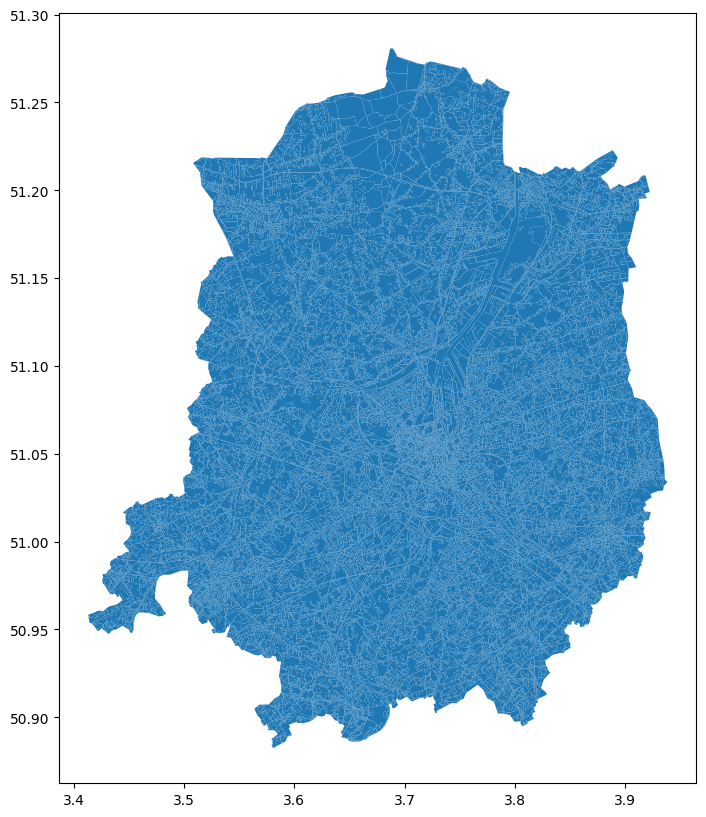

In [471]:
# Plot the polygons
gent_shapefile.plot(figsize=(10, 10))
plt.show()

### 1. Pre Processing

**Preprocessing** plays a crucial role not just in preparing datasets to suit our specific needs, but also in addressing any inconsistencies that may be present, such as missing values or outliers

####1.1 Datasets



---

Dataset "data_sector"

---



In [472]:
# Before starting the preprocessing, we will create a copy of the dataset so that we can make some changes
data_sector = data_se.copy()

Since we are only focussing on **Gent**, the other municipalities are not relevant. We will **filter the rows by Gent** and **drop the Municipality** variable.

**note**: After filtering to only display Gent, **'Province'** ends up with only 1 value, which is pointless, we will also drop this column

In [473]:
# Filtering the values to only keep results from GENT
data_sector = data_sector[data_sector['Main municipality'] == 'GENT']

# Dropping these columns since they no longer have a purpose
data_sector.drop('Main municipality', axis=1, inplace=True)
data_sector.drop('Province', axis=1, inplace=True)

**Incoherences**

There are some rows in **'Statistical sector'** with 'zzzz' as the last 4 digits, we will drop them since these codes must have 8 or 9 digits

In [474]:
# Counting how many rows have this issue
count = len(data_sector[data_sector['Statistical sector'].str.endswith("zzzz")])
print(count)

54


In [475]:
data_sector = data_sector[~data_sector.astype(str).apply(lambda row: row.str.contains("zzzz")).any(axis=1)]

**Missing values**

Since we dropped many rows, we will verify again the number of missing values

In [476]:
data_sector.isna().sum()

Consumption year               0
Type of consumption            0
Direction                      0
Statistical sector             0
Subsector                      0
Sector                         0
Role contact                   0
Number                         0
Estimated consumption (kWh)    3
dtype: int64

In [477]:
# There are still 3 rows with missing values, since these are missing at random, we will remove them
data_sector.dropna(subset=['Estimated consumption (kWh)'], inplace=True)

**Encoding variables**

For the following cells, we will be renaming the columns and transformint the variables into binary indicators, **dummy variables**.

In [478]:
# For 'Type of consumption', the options are Electricity and Natural Gas
data_sector['Type of consumption'] = data_sector['Type of consumption'].replace({'Elektriciteit': '1', 'Aardgas': '0'})

# Renaming the column to the most common value
data_sector.rename(columns={'Type of consumption': 'Electricity'}, inplace=True)
data_sector['Electricity'].value_counts()

1    6280
0    4845
Name: Electricity, dtype: int64

In [479]:
# For 'Role contact', the options are Company and Person
data_sector['Role contact'] = data_sector['Role contact'].replace({'Bedrijf': '1', 'Persoon': '0'})

# Renaming the column to the most common value
data_sector.rename(columns={'Role contact': 'Company'}, inplace=True)
data_sector['Company'].value_counts()

1    9673
0    1452
Name: Company, dtype: int64

In [480]:
# For 'Direction', the options are Offtake and Injection
data_sector['Direction'] = data_sector['Direction'].replace({'Afname': '1', 'Injectie': '0'})

# Renaming the column to the most common value
data_sector.rename(columns={'Direction': 'Offtake'}, inplace=True)
data_sector['Offtake'].value_counts()

1    10991
0      134
Name: Offtake, dtype: int64

**Note**, to clarify the meaning of this variable:
* **Offtake**: represents the **purchase** of electricity and/or natural gas from the distribution network and is represented by **1**
* **Injection**: represents the **surplus** of energy produced by the grid user and supplied back to the distribution grid, represented by **0**

**Changing DataTypes**

In [481]:
data_sector.dtypes

Consumption year                 int64
Electricity                     object
Offtake                         object
Statistical sector              object
Subsector                       object
Sector                          object
Company                         object
Number                         float64
Estimated consumption (kWh)    float64
dtype: object

In [482]:
# Changing datatypes of the type of the newly binary variables
data_sector['Electricity'] = data_sector['Electricity'].astype(int)
data_sector['Offtake'] = data_sector['Offtake'].astype(int)
data_sector['Company'] = data_sector['Company'].astype(int)

# Setting 'Consumption year' and 'Number' as int types
data_sector['Consumption year'] = data_sector['Consumption year'].astype(int)
data_sector['Number'] = data_sector['Number'].astype(int)

# Rounding 'Estimated consumption (kWh)' to the decimals
data_sector['Estimated consumption (kWh)'] = data_sector['Estimated consumption (kWh)'].round(2)

In [483]:
data_sector['Number'].value_counts()

4       1420
3       1182
5       1038
6        669
7        505
        ... 
617        1
1227       1
955        1
289        1
1253       1
Name: Number, Length: 698, dtype: int64

In [484]:
data_sector

,Consumption year,Electricity,Offtake,Statistical sector,Subsector,Sector,Company,Number,Estimated consumption (kWh)
13990,2018,0,1,44021A00-,Andere industrie,Industrie,1,4,92780.44
13991,2018,0,1,44021A00-,Empty/onbekend,Empty/onbekend,1,25,490093.57
13992,2018,0,1,44021A00-,Handel,Tertiaire sector,1,92,2334618.93
13993,2018,0,1,44021A00-,Horeca,Tertiaire sector,1,135,12073332.73
13994,2018,0,1,44021A00-,Huishoudelijk,Huishoudens,0,264,3401717.09
...,...,...,...,...,...,...,...,...,...
397444,2021,1,1,44021M472,Kantoren en administraties,Tertiaire sector,1,4,34645.72
397445,2021,1,1,44021M472,Rest,Empty/onbekend,1,3,633.13
397446,2021,1,1,44021M472,Rest,Rest,1,4,5319633.88
397447,2021,1,1,44021M57-,Rest,Rest,1,4,5442700.06




---

Dataset "data_street"

---



In [485]:
# Before starting the preprocessing, we will create a copy of the dataset so that we can make some changes
data_street = data_st.copy()

Since we are only focussing on **Gent**, the other municipalities are not relevant. We will **filter the rows by Gent** and **drop the Municipality** variable.

**note**: After this, Region becomes pointless too (as it only has 1 unique value), so we will also drop it

In [486]:
# Filtering the values to only keep results from GENT
data_street = data_street[data_street['Main municipality'] == 'GENT']

# Dropping these columns since they no longer have a purpose
data_street.drop('Main municipality', axis=1, inplace=True)
data_street.drop('Region', axis=1, inplace=True)

In [487]:
data_street.head(3)

,Consumption year,Type of consumption,Direction,Street,Nº access points,Estimated consumption (kWh)
1,2011,Aardgas,Afname,BAVIAANSTRAAT,63,135417.83
3,2011,Aardgas,Afname,BEEMDSTRAAT,3,69296.93
5,2011,Aardgas,Afname,BEGIJNHOFLAAN,204,3181014.28


In [488]:
data_street["Street"].value_counts()

WIEDAUWKAAI                 33
INDUSTRIEWEG                33
SKALDENSTRAAT               33
TERDONKKAAI                 32
EDDASTRAAT                  32
                            ..
MARTHE VERSICHELENSTRAAT     1
RAVELIJNSTRAAT               1
ELIANE VOGEL-POLSKYPAD       1
SPOREWEGEL                   1
SPRENDONKSTRAAT              1
Name: Street, Length: 2527, dtype: int64

**Encoding variables**

For the following cells, we will be renaming the columns and transformint the variables into binary indicators, **dummy variables**.

In [489]:
# For 'Type of consumption', the options are Electricity and Natural Gas
data_street['Type of consumption'] = data_street['Type of consumption'].replace({'Elektriciteit': '1', 'Aardgas': '0'})

# Renaming the column to the most common value
data_street.rename(columns={'Type of consumption': 'Electricity'}, inplace=True)
data_street['Electricity'].value_counts()

1    26525
0    24713
Name: Electricity, dtype: int64

In [490]:
# For 'Direction', the options are Offtake and Injection
data_street['Direction'] = data_street['Direction'].replace({'Afname': '1', 'Injectie': '0'})

# Renaming the column to the most common value
data_street.rename(columns={'Direction': 'Offtake'}, inplace=True)
data_street['Offtake'].value_counts()

1    50995
0      243
Name: Offtake, dtype: int64

**Changing DataTypes**

In [491]:
data_street.dtypes

Consumption year                 int64
Electricity                     object
Offtake                         object
Street                          object
Nº access points                 int64
Estimated consumption (kWh)    float64
dtype: object

In [492]:
# Changing datatypes of the variables
data_street['Electricity'] = data_street['Electricity'].astype(int)
data_street['Offtake'] = data_street['Offtake'].astype(int)
data_street['Street'] = data_street['Street'].astype(str)

# Setting 'Consumption year' and 'Number' as int types
data_street['Consumption year'] = data_street['Consumption year'].astype(int)

# Rounding 'Estimated consumption (kWh)' to the decimals
data_street['Estimated consumption (kWh)'] = data_street['Estimated consumption (kWh)'].round(2)

In [493]:
data_street

,Consumption year,Electricity,Offtake,Street,Nº access points,Estimated consumption (kWh)
1,2011,0,1,BAVIAANSTRAAT,63,135417.83
3,2011,0,1,BEEMDSTRAAT,3,69296.93
5,2011,0,1,BEGIJNHOFLAAN,204,3181014.28
7,2011,0,1,BELGIELAAN,19,420146.71
9,2011,0,1,BELLEFLEURSTRAAT,61,704951.14
...,...,...,...,...,...,...
1278329,2016,1,1,ZWANENBERG,3,39195.32
1278330,2016,1,0,INDUSTRIEWEG,9,6388553.17
1278331,2016,1,0,REST - MARIAKERKE,5,624434.54
1278332,2016,1,0,REST - SINT-DENIJS-WESTREM,4,622014.39


In [494]:
data_street['Street'].value_counts()

WIEDAUWKAAI                 33
INDUSTRIEWEG                33
SKALDENSTRAAT               33
TERDONKKAAI                 32
EDDASTRAAT                  32
                            ..
MARTHE VERSICHELENSTRAAT     1
RAVELIJNSTRAAT               1
ELIANE VOGEL-POLSKYPAD       1
SPOREWEGEL                   1
SPRENDONKSTRAAT              1
Name: Street, Length: 2528, dtype: int64



---

**Dataset "data_ev"**

---



In [495]:
# Before starting the preprocessing, we will create a copy of the dataset so that we can make some changes
data_ev = data_e.copy()

In [496]:
data_ev.shape

(2153, 9)

In the data dictionary, it was mentioned that there were 3 **'Postal code'** variables, of which, 2 should be discarded.

In [497]:
# Dropping these columns since they dont bring any new information
data_ev.drop('Postal code (for visualizing)', axis=1, inplace=True)
data_ev.drop('Postal code numerical', axis=1, inplace=True)

In the data dictionary, it was mentioned that the **'Unique orderID'** is an internal ID and it should be discarded.

In [498]:
# Dropping this column
data_ev.drop('Unique orderID', axis=1, inplace=True)

Also, in the descriptive statistics we noticed that '**Voltage level**' only has **one unique value, LS** (low voltage).

After acknowledging this, we will drop this variable as well

In [499]:
data_ev.drop('Voltage level', axis=1, inplace=True)

For now we will drop '**geom**' since we're having issues with it

In [500]:
data_ev.drop('geom', axis=1, inplace=True)

Since we are only working in Gent, we will be filtering the '**Postal code**' to exclude the ones that arent from Gent

In [501]:
gent_codes = [9000, 9030, 9031, 9032, 9040, 9041, 9042, 9050, 9051, 9052]

data_ev = data_ev[data_ev['Postal code'].isin(gent_codes)]
data_ev

,Connection year,Postal code,Max Power (kVA),centroid
78,2012,9000,143.00,"51.074456842,3.7255309739999998"
93,2017,9000,22.20,"51.074456842,3.7255309739999998"
98,2018,9050,22.20,"51.074456842,3.7255309739999998"
99,2017,9000,22.20,"51.074456842,3.7255309739999998"
100,2017,9000,22.20,"51.074456842,3.7255309739999998"
...,...,...,...,...
2045,2021,9040,22.20,"51.074456842,3.7255309739999998"
2068,2021,9042,22.20,"51.074456842,3.7255309739999998"
2089,2021,9000,22.20,"51.074456842,3.7255309739999998"
2124,2021,9000,22.20,"51.074456842,3.7255309739999998"


The column **'centroid'** has coordenates together, so we will split this to obtain the latitude and longitude

In [502]:
# Split the coordinates from 'centroid' into Lat and Long
data_ev[['Lat', 'Long']] = data_ev['centroid'].str.split(',', expand=True)

# convert the coordinates to floats
data_ev[['Lat', 'Long']] = data_ev[['Lat', 'Long']].astype(float)

# and then we drop the column position as it is no longer relevant
data_ev.drop(['centroid'], axis=1, inplace=True)

In [503]:
data_ev

,Connection year,Postal code,Max Power (kVA),Lat,Long
78,2012,9000,143.00,51.07,3.73
93,2017,9000,22.20,51.07,3.73
98,2018,9050,22.20,51.07,3.73
99,2017,9000,22.20,51.07,3.73
100,2017,9000,22.20,51.07,3.73
...,...,...,...,...,...
2045,2021,9040,22.20,51.07,3.73
2068,2021,9042,22.20,51.07,3.73
2089,2021,9000,22.20,51.07,3.73
2124,2021,9000,22.20,51.07,3.73




---

Dataset "data_storage"

---



In [504]:
# Before starting the preprocessing, we will create a copy of the dataset so that we can make some changes
data_storage = data_sto.copy()

In the data dictionary, it was mentioned that the **'Unique orderID'** is an internal ID and it should be discarded.

In [505]:
# Dropping this column
data_storage.drop('Unique orderID', axis=1, inplace=True)

In the descriptive statistics we noticed that '**Technology type**' only has **one unique value, Thuisbatterij** (Home battery).

After acknowledging this, we will drop this variable as well

In [506]:
data_storage.drop('Technology type', axis=1, inplace=True)

The variable '**Voltage level**' is too unbalanced, almost all values are **LS**, so we will drop it, since it is not adding new information

In [507]:
data_storage['Voltage level'].value_counts()

LS    35837
MS        8
Name: Voltage level, dtype: int64

In [508]:
data_storage.drop('Voltage level', axis=1, inplace=True)

**Incoherences**

**Missing values**

Since we dropped some rows, we will verify again the number of missing values

In [509]:
data_storage.isna().sum()

Date of commissioning     16
Year                      16
Month                     16
Storage capacity (kWh)    14
Inverter power (kVA)       0
dtype: int64

The missing values in the date columns will all be in the same rows. We will drop the missing values in **'Date of commissioning'**

In [510]:
data_storage = data_storage.dropna(subset=['Date of commissioning'])

# As suspected the missing values were on the same rows

Since '**Storage capacity**' is very positively skewed, anmd the values are missing at random, we will fill the missing values with the median

In [511]:
data_storage['Storage capacity (kWh)'] = data_storage['Storage capacity (kWh)'].fillna(data_storage['Storage capacity (kWh)'].median())

**Changing DataTypes**

In [512]:
data_storage.dtypes

Date of commissioning      object
Year                      float64
Month                     float64
Storage capacity (kWh)    float64
Inverter power (kVA)      float64
dtype: object

In [513]:
data_storage['Year'] = data_storage['Year'].astype(int)
data_storage['Month'] = data_storage['Month'].astype(int)

In [514]:
data_storage

,Date of commissioning,Year,Month,Storage capacity (kWh),Inverter power (kVA)
0,2022-10,2022,10,4.56,3.00
1,2022-10,2022,10,10.00,5.00
2,2022-10,2022,10,4.40,4.00
3,2022-10,2022,10,5.70,4.60
4,2022-10,2022,10,10.12,5.00
...,...,...,...,...,...
35840,2019-03,2019,3,6.00,6.48
35841,2019-03,2019,3,9.60,13.80
35842,2018-12,2018,12,10.00,5.00
35843,2018-06,2018,6,9.60,2000.00




---

Dataset "data_decentral"

---



In [515]:
# Before starting the preprocessing, we will create a copy of the dataset so that we can make some changes
data_decentral = data_dc.copy()

The data dictionary mentioned to **'Postal code (hierarchical)'** and **'Unique orderID'**

In [516]:
# Dropping these columns since they dont bring any new information
data_decentral.drop('Postal code (hierarchical)', axis=1, inplace=True)
data_decentral.drop('Unique orderID', axis=1, inplace=True)

As seen in descriptive statistcis, '**Technology type**' only has one value **Zonne-Energie (PV)**, Solar

In [517]:
data_decentral['Technology type'].value_counts()

Zonne-Energie (PV)     619150
WKK Aardgas               657
Windenergie               375
Brandstofcel              276
WKK Biomassa/Biogas       210
Andere                    202
Name: Technology type, dtype: int64

In [518]:
data_decentral.drop('Technology type', axis=1, inplace=True)

Since we are only interested in data from **Gent**, we will be filtering the **'Postal code'**

In [519]:
gent_codes = [9000, 9030, 9031, 9032, 9040, 9041, 9042, 9050, 9051, 9052]

data_decentral = data_decentral[data_decentral['Postal code'].isin(gent_codes)]
data_decentral

,Year of commissioning,Max power (kVA),Voltage level,Municipality code,Postal code
107751,2020.00,4.00,LS,44021.00,9040.00
107752,2011.00,5.30,LS,44021.00,9040.00
107753,2011.00,9.00,LS,44021.00,9040.00
107754,2011.00,3.60,LS,44021.00,9040.00
107755,2011.00,4.20,LS,44021.00,9040.00
...,...,...,...,...,...
554373,2020.00,2.50,LS,44021.00,9040.00
554374,2020.00,3.50,LS,44021.00,9040.00
554375,2019.00,3.00,LS,44021.00,9040.00
554376,2020.00,4.00,LS,44021.00,9040.00


After filtering, **'Municipality code** becomes pointless, we will drop this

In [520]:
data_decentral['Municipality code'].value_counts()

44021.00    14479
Name: Municipality code, dtype: int64

In [521]:
data_decentral.drop('Municipality code', axis=1, inplace=True)

**Incoherences**

**Missing values**

Since we dropped some rows, we will verify again the number of missing values

In [522]:
data_decentral.isna().sum()

Year of commissioning    26
Max power (kVA)           0
Voltage level             0
Postal code               0
dtype: int64

Since we cant know the '**Year of commissioning**', we will drop the rows with missing values

In [523]:
data_decentral.dropna(subset=['Year of commissioning'], inplace=True)

**Changing DataTypes**

In [524]:
data_decentral.dtypes

Year of commissioning    float64
Max power (kVA)          float64
Voltage level             object
Postal code              float64
dtype: object

In [525]:
data_decentral['Year of commissioning'] = data_decentral['Year of commissioning'].astype(int)
data_decentral['Postal code'] = data_decentral['Postal code'].astype(int)

In [526]:
data_decentral

,Year of commissioning,Max power (kVA),Voltage level,Postal code
107751,2020,4.00,LS,9040
107752,2011,5.30,LS,9040
107753,2011,9.00,LS,9040
107754,2011,3.60,LS,9040
107755,2011,4.20,LS,9040
...,...,...,...,...
554373,2020,2.50,LS,9040
554374,2020,3.50,LS,9040
554375,2019,3.00,LS,9040
554376,2020,4.00,LS,9040




---

Dataset "data_local"

---



In [527]:
# Before starting the preprocessing, we will create a copy of the dataset so that we can make some changes
data_local = data_loc.copy()

In [528]:
data_local.head()

,Reference date,Responsible distributor,Main municipality,Technology,Nº installations,Installed power (kVA)
0,2022-10,Niet toegewezen,Niet toegewezen,ZONNE-ENERGIE,25,2420.60
1,2022-10,FLUVIUS ANTWERPEN,AARTSELAAR,ZONNE-ENERGIE,1401,9294.76
2,2022-10,FLUVIUS ANTWERPEN,ANTWERPEN,BIOMASSA (GEEN WKK),6,20469.00
3,2022-10,FLUVIUS ANTWERPEN,ANTWERPEN,BRANDSTOFCEL,8,30.75
4,2022-10,FLUVIUS ANTWERPEN,ANTWERPEN,DIESEL (GEEN WKK),7,9020.00


In [529]:
data_local["Main municipality"].value_counts()

GENT               9
ANTWERPEN          9
GEEL               8
LEUVEN             8
HASSELT            7
                  ..
BREDENE            1
WEZEMBEEK-OPPEM    1
HAMONT-ACHEL       1
GALMAARDEN         1
WEMMEL             1
Name: Main municipality, Length: 301, dtype: int64

Since we only want the rows from **Gent** we filtered the dataset here

In [530]:
data_local = data_local[data_local['Main municipality'] == 'GENT']

# Display the filtered dataframe
data_local.head()

,Reference date,Responsible distributor,Main municipality,Technology,Nº installations,Installed power (kVA)
172,2022-10,IMEWO,GENT,BIOMASSA (GEEN WKK),2,26644.00
173,2022-10,IMEWO,GENT,DIESEL (GEEN WKK),5,10850.00
174,2022-10,IMEWO,GENT,NOODGROEP TYPE1,1,800.00
175,2022-10,IMEWO,GENT,NOODGROEP TYPE2,10,16350.00
176,2022-10,IMEWO,GENT,WKK BIOMASSA/BIOGAS,4,1770.00




---

Dataset "data_income"

---



In [531]:
# Before starting the preprocessing, we will create a copy of the dataset so that we can make some changes
data_income = data_inc.copy()

**Incoherences**

There were some values in all income rows with 'x' instead of a value

In [532]:
 # How many rows have this issue
datatemp = data_income.copy()
values_x = (datatemp.astype(str) == 'x').any(axis=1).sum()

print(f"{values_x} rows have at at least one value 'x'")

20 rows have at at least one value 'x'


In [533]:
# The rows with this issue
rows_with_x = datatemp[datatemp.astype(str).eq('x').any(axis=1)]
rows_with_x

,Sector,Avg Income 2005,Avg Income 2006,Avg Income 2007,Avg Income 2008,Avg Income 2009,Avg Income 2010,Avg Income 2011,Avg Income 2012,Avg Income 2013,Avg Income 2014,Avg Income 2015,Avg Income 2016,Avg Income 2017,Avg Income 2018,Avg Income 2019
14,Blauwpoort,10492,9569,12152,x,x,x,x,x,x,x,16385,19184,20569,23684,20451
17,Brug Zuidwest,x,x,x,15054,15448,15495,16232,18276,17678,18342,18578,18859,19199,20224,20511
20,Bugten,x,x,x,x,x,x,x,x,x,13422,15466,20543,25558,28586,27813
23,Coninxdonk,x,x,x,23985,22984,23752,25874,26428,x,x,x,x,x,x,x
37,Drongense Meersen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,20055,19001,19997,20366,20292,20916
42,Flora,10407,10736,11341,x,x,x,x,x,16255,17905,16797,16707,17525,17162,18065
67,Keizerspark,15529,17167,15584,x,x,x,x,x,23224,24299,24261,26304,27608,26828,25556
88,Malem,7608,7665,7815,9773,8997,8458,8309,8620,x,8918,8859,9036,9382,9332,9691
94,Moscou,12195,11953,12661,x,x,x,x,x,16808,18836,19246,21702,22392,21635,22812
100,Nieuwgoed,17257,19147,16680,23851,24969,23381,28070,26551,26188,25007,27094,27269,x,33405,x


In [534]:
data_income.drop(rows_with_x.index, inplace=True)

**Missing values**

Since we dropped some rows, we will verify again the number of missing values

In [535]:
data_income.isna().sum()

Sector             0
Avg Income 2005    0
Avg Income 2006    0
Avg Income 2007    0
Avg Income 2008    0
Avg Income 2009    0
Avg Income 2010    0
Avg Income 2011    0
Avg Income 2012    0
Avg Income 2013    0
Avg Income 2014    0
Avg Income 2015    0
Avg Income 2016    0
Avg Income 2017    0
Avg Income 2018    0
Avg Income 2019    0
dtype: int64

**Changing DataTypes**

In [536]:
data_income.dtypes

Sector             object
Avg Income 2005    object
Avg Income 2006    object
Avg Income 2007    object
Avg Income 2008    object
Avg Income 2009    object
Avg Income 2010    object
Avg Income 2011    object
Avg Income 2012    object
Avg Income 2013    object
Avg Income 2014    object
Avg Income 2015    object
Avg Income 2016    object
Avg Income 2017    object
Avg Income 2018    object
Avg Income 2019    object
dtype: object

In [537]:
# Changing datatypes of the type of the newly binary variables
years = ['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']

for year in years:
    income_col = 'Avg Income ' + year
    data_income[income_col] = data_income[income_col].astype(int)

In [538]:
data_income

,Sector,Avg Income 2005,Avg Income 2006,Avg Income 2007,Avg Income 2008,Avg Income 2009,Avg Income 2010,Avg Income 2011,Avg Income 2012,Avg Income 2013,Avg Income 2014,Avg Income 2015,Avg Income 2016,Avg Income 2017,Avg Income 2018,Avg Income 2019
0,'T Schaarken,15798,16102,17171,17313,18719,17738,18672,19719,19584,20195,19385,19396,21034,21301,21528
1,Aaigem,20026,20716,21215,22769,22293,22840,24048,24689,25266,26007,25060,26309,27145,27914,26573
2,Afrikalaan,9698,9994,10104,10547,10444,10177,10162,10891,10658,10813,10633,10452,11194,11913,12551
3,Afsnee - Centrum,18571,20131,20216,21892,22118,22991,21650,23754,25673,24109,28997,26759,25726,31444,32092
4,Akademisch Ziekenhuis,4264,5466,8376,20458,12582,11311,11200,10287,13062,17362,19001,21153,20214,20404,23023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,Wondelgemstraat,7455,7945,8330,8588,8676,8616,9055,9690,9705,9862,9931,10238,10676,10946,11358
162,Zonneput,14629,14742,15224,20933,18281,17717,17935,19398,20170,22110,20908,21723,21699,21923,22594
163,Zuidpark,18903,19496,19631,17399,22334,21857,22232,23319,23193,23353,23093,23118,23298,23664,23952
165,Zwijnaarde - Centrum,15747,16320,17056,17566,19296,18259,18621,19296,19636,20329,20027,21158,21942,21583,22710




---

Dataset "data_rent"

---



In [539]:
# Before starting the preprocessing, we will create a copy of the dataset so that we can make some changes
data_rent = data_r.copy()

Since dataset is only focussing on **Gent**, the **'Country', 'Region', 'Province' and 'District' are all the same**, which makes this variables redundant, we will drop them

In [540]:
# Dropping these columns since they dont bring any new information
data_rent.drop('Country', axis=1, inplace=True)
data_rent.drop('Region', axis=1, inplace=True)
data_rent.drop('Province', axis=1, inplace=True)
data_rent.drop('District', axis=1, inplace=True)

# Also dropping 'Unnamed: 0 ' since it has no meaning
data_rent.drop('Unnamed: 0', axis=1, inplace=True)

The columns **'Type'** and **'Price type'** both only have one value, meaning all the listed rents are regarding **Apartments** and their respective **Residential ronthly rent**

After acknowledging this information, we will drop the columns as they bring no other information

In [541]:
data_rent.drop('Type', axis=1, inplace=True)
data_rent.drop('Price type', axis=1, inplace=True)

There are too many **'Locality'**, many of them with a single value, so we will **group them by 'Postal code'**

In [542]:
data_rent['Locality'].value_counts()

Gent                        369
Sint-Denijs-Westrem           9
Mariakerke                    8
Gentbrugge                    7
Ghent                         6
Sint-Amandsberg               5
Ledeberg                      4
St-Amandsberg                 4
SINT-DENIJS-WESTREM           3
Wondelgem                     3
Zwijnaarde                    3
Oostakker                     2
SINT-AMANDSBERG               2
Drongen                       2
GENTBRUGGE                    2
Gent Sint-Denijs-Westrem      1
Gand                          1
Gent Zwijnaarde               1
Gent (Wondelgem)              1
GENT                          1
GENT CENTRUM                  1
Ledeberg                      1
St-Denijs-Westrem             1
Gent (9000)                   1
Sint-Amandsberg (Gent)        1
Name: Locality, dtype: int64

In [543]:
data_rent['Postal code'].value_counts()

9000    358
9050     21
9040     20
9051     18
9030      8
9052      6
9032      4
9031      2
9041      2
Name: Postal code, dtype: int64

In [544]:
data_rent['Locality'] = data_rent.groupby('Postal code')['Locality'].transform('max')
data_rent['Locality'].value_counts()

Ghent                358
Ledeberg              21
St-Amandsberg         20
St-Denijs-Westrem     18
Mariakerke             8
Zwijnaarde             6
Wondelgem              4
Drongen                2
Oostakker              2
Name: Locality, dtype: int64

**Incoherences**

Some 'Street number' have a ',' in the number

In [545]:
 # How many rows have this issue
datatemp = data_rent.copy()
number_with_comma = (datatemp['Street number'].astype(str).str.contains(',')).sum()

print(f"{number_with_comma} rows have at least one value containing ','")

102 rows have at least one value containing ','


In [546]:
data_rent['Street number'] = data_rent['Street number'].fillna('').astype(str)
data_rent = data_rent[~data_rent['Street number'].str.contains(',')]

**Missing values**

Since we dropped some rows, we will verify again the number of missing values

In [547]:
data_rent.isna().sum()

ID                          0
Bedroom count               0
Price main value            0
Price additional value    154
Locality                    0
Postal code                 0
Street                     11
Street number               0
Lat                        11
Long                       11
Floor                       0
Net Habitable Surface      74
dtype: int64

The variable **'Price additional value'** has the following description: additional rent price (heating, etc) per month in euros.

>As such, the detected missing values are missing not at random, if there are no additional expenses, there are no records. **We will fill these missing values with 0**

In [548]:
data_rent['Price additional value'] = data_rent['Price additional value'].fillna(0)

The 11 rows missing in the variables related to the **Street** will be all in the same rows, if we delete the missing values for one row, the others will also be removed

In [549]:
data_rent = data_rent.dropna(subset=['Street'])

# As suspected, the missing values were in the same rows

We will print the rows with the missing street numbers, to try to discover them

In [550]:
rows_missing_street_number = data_rent[data_rent['Street number'].isna()]
rows_missing_street_number

,ID,Bedroom count,Price main value,Price additional value,Locality,Postal code,Street,Street number,Lat,Long,Floor,Net Habitable Surface


Since we were not able to match the coordinates to any location on the same Street, we looked up the coordinates on **Google maps** and discovered the Street number

In [551]:
data_rent.at[136, 'Street number'] = '25'
data_rent.at[160, 'Street number'] = '17'
data_rent.at[136, 'Street number'] = '51'

Finally **Net Habitable Surface** has too many missing values, we will drop this variable

In [552]:
data_rent.drop('Net Habitable Surface', axis=1, inplace=True)

**Changing DataTypes**

In [553]:
data_rent.dtypes

ID                          int64
Bedroom count               int64
Price main value            int64
Price additional value    float64
Locality                   object
Postal code                 int64
Street                     object
Street number              object
Lat                       float64
Long                      float64
Floor                       int64
dtype: object

In [554]:
# Some values in 'Street number' have A, B or C in front of it, therefore we cant convert this no int
# data_rent['Street number'] = data_rent['Street number'].astype(int)

#### 1.2 Datasets Merged

In [555]:
# merge data_decentral and data_rent by using column Postal code

# Select specific columns
selected_columns_decentral = ['Postal code', 'Year of commissioning', 'Max power (kVA)']
selected_columns_rent = ['Street', 'Postal code', 'Lat', 'Long', 'Price main value', 'Price additional value']

data_rent_temp = data_rent[selected_columns_rent]
data_decentral_temp = data_decentral[selected_columns_decentral]

data_decentral_agg = data_decentral_temp.groupby('Postal code').agg({
    'Year of commissioning': lambda x: x.mode().iloc[0],
    'Max power (kVA)': 'mean',
})

# Perform a left join to merge the datasets
merged_1 = pd.merge(data_rent_temp, data_decentral_agg, on='Postal code', how='left')

# Forward fill the values for each postal code
merged_1['Year of commissioning'].fillna(method='ffill', inplace=True)
merged_1['Max power (kVA)'].fillna(method='ffill', inplace=True)

In [556]:
selected_columns_street = ['Street', 'Estimated consumption (kWh)']
data_street_temp = data_street[selected_columns_street]

#Pass to lower case
data_street_temp['Street'] = data_street_temp['Street'].str.lower()
merged_1['Street'] = merged_1['Street'].str.lower()

data_street_agg = data_street_temp.groupby('Street').agg({
    'Estimated consumption (kWh)': 'mean',
})

# Perform a left join to merge the datasets
merged_2 = pd.merge(merged_1, data_street_agg, on='Street', how='left')

# Forward fill the values for each postal code
merged_2['Estimated consumption (kWh)'].fillna(method='ffill', inplace=True)

pd.options.display.float_format = '{:.2f}'.format
# Create a new column 'Money spent on energy' by multiplying 'Estimated consumption (kWh)' by 0.48
merged_2['Money spent on energy (€)'] = merged_2['Estimated consumption (kWh)'] * 0.48

In [557]:
merged_2["Postal code"].value_counts()


9000    258
9050     18
9040     17
9051     16
9030      6
9052      4
9032      4
9041      2
9031      1
Name: Postal code, dtype: int64

In [558]:
data_rent.columns

Index(['ID', 'Bedroom count', 'Price main value', 'Price additional value',
       'Locality', 'Postal code', 'Street', 'Street number', 'Lat', 'Long',
       'Floor'],
      dtype='object')

In [559]:
merged_2.head()

,Street,Postal code,Lat,Long,Price main value,Price additional value,Year of commissioning,Max power (kVA),Estimated consumption (kWh),Money spent on energy (€)
0,dendermondsesteenweg,9000,51.06,3.74,1300,50.00,2020,7.16,7565693.48,3631532.87
1,dendermondsesteenweg,9000,51.06,3.74,1500,75.00,2020,7.16,7565693.48,3631532.87
2,brusselsesteenweg,9050,51.04,3.75,790,60.00,2020,4.23,9486608.34,4553572.00
3,brugsesteenweg,9030,51.08,3.68,950,0.00,2020,4.91,7800221.36,3744106.25
4,brugsesteenweg,9030,51.07,3.68,925,0.00,2020,4.91,7800221.36,3744106.25


Merge_2 with **data_storage**

In [560]:
merged_2 = merged_2.rename(columns={'Year of commissioning': 'Year'})

In [561]:
selected_columns_storage = ['Year', 'Storage capacity (kWh)', 'Inverter power (kVA)']
data_selected_storage = data_storage[selected_columns_storage]

In [562]:
# Aggregate selected_columns_ev by postal code
data_storage_agg = data_selected_storage.groupby('Year').agg({
     'Storage capacity (kWh)': 'mean',
    'Inverter power (kVA)': 'mean'
}).reset_index()

# Perform a left join to merge the datasets
merged_3 = pd.merge(merged_2, data_storage_agg, on='Year', how='left')
merged_3.head()

,Street,Postal code,Lat,Long,Price main value,Price additional value,Year,Max power (kVA),Estimated consumption (kWh),Money spent on energy (€),Storage capacity (kWh),Inverter power (kVA)
0,dendermondsesteenweg,9000,51.06,3.74,1300,50.00,2020,7.16,7565693.48,3631532.87,8.78,9.29
1,dendermondsesteenweg,9000,51.06,3.74,1500,75.00,2020,7.16,7565693.48,3631532.87,8.78,9.29
2,brusselsesteenweg,9050,51.04,3.75,790,60.00,2020,4.23,9486608.34,4553572.00,8.78,9.29
3,brugsesteenweg,9030,51.08,3.68,950,0.00,2020,4.91,7800221.36,3744106.25,8.78,9.29
4,brugsesteenweg,9030,51.07,3.68,925,0.00,2020,4.91,7800221.36,3744106.25,8.78,9.29


In [563]:
merged_3['Main_Price_Plus_Aditional'] = merged_3['Price main value'] + merged_3['Price additional value']

#### 1.3 Feature Engineering

Here we thought about creating a variable that we want to minimize in order to create these community clusters. For that we created `Money_spent_on_energy_(%)` that corresponds to the percentage of the house rent that is used to pay the energy consumption.

In [564]:
# First we need to convert everything to year
# so we multiplied the Price main value by 12 and summed the adicional prices
# then we multiplied by 80, assuming that we have 40 buildings per street, 2 appartments in each
merged_3['Rent_Prices'] = (merged_3['Price main value']*12 + merged_3['Price additional value']*12) * 80

merged_3['Money_spent_on_energy_(%)'] = merged_3['Rent_Prices'] / merged_3['Money spent on energy (€)']

merged_3.head()

,Street,Postal code,Lat,Long,Price main value,Price additional value,Year,Max power (kVA),Estimated consumption (kWh),Money spent on energy (€),Storage capacity (kWh),Inverter power (kVA),Main_Price_Plus_Aditional,Rent_Prices,Money_spent_on_energy_(%)
0,dendermondsesteenweg,9000,51.06,3.74,1300,50.00,2020,7.16,7565693.48,3631532.87,8.78,9.29,1350.00,1296000.00,0.36
1,dendermondsesteenweg,9000,51.06,3.74,1500,75.00,2020,7.16,7565693.48,3631532.87,8.78,9.29,1575.00,1512000.00,0.42
2,brusselsesteenweg,9050,51.04,3.75,790,60.00,2020,4.23,9486608.34,4553572.00,8.78,9.29,850.00,816000.00,0.18
3,brugsesteenweg,9030,51.08,3.68,950,0.00,2020,4.91,7800221.36,3744106.25,8.78,9.29,950.00,912000.00,0.24
4,brugsesteenweg,9030,51.07,3.68,925,0.00,2020,4.91,7800221.36,3744106.25,8.78,9.29,925.00,888000.00,0.24


#### 1.4 Grid Merge

In this section we joined the `merged_3` dataset with the geopandas one with the grid of Gent (`gent_shapefile`).

In [565]:
# create a Point geometry column in merged_3
geometry = [Point(xy) for xy in zip(merged_3.Long, merged_3.Lat)]

# convert merged_3 to a GeoDataFrame
merged_3 = gpd.GeoDataFrame(merged_3, geometry = geometry, crs = gent_shapefile.crs)
merged_3.crs = "EPSG:4326"

In [566]:
merged_3['Polygon'] = ''

# loop through the polygons in the gent_shapefile GeoDataFrame
for idx, row in gent_shapefile.iterrows():
    # create a boolean mask for the points in the merged_3 that are contained within the polygon
    mask = merged_3['geometry'].within(row['geometry'])
    # set the 'Polygon' value for the points that satisfy the mask
    merged_3.loc[mask, 'Polygon'] = row['geometry']

In [567]:
merged_3 = merged_3.drop(columns="geometry")
merged_3.head()

,Street,Postal code,Lat,Long,Price main value,Price additional value,Year,Max power (kVA),Estimated consumption (kWh),Money spent on energy (€),Storage capacity (kWh),Inverter power (kVA),Main_Price_Plus_Aditional,Rent_Prices,Money_spent_on_energy_(%),Polygon
0,dendermondsesteenweg,9000,51.06,3.74,1300,50.00,2020,7.16,7565693.48,3631532.87,8.78,9.29,1350.00,1296000.00,0.36,POLYGON ((3.7426977409540507 51.05648214004452...
1,dendermondsesteenweg,9000,51.06,3.74,1500,75.00,2020,7.16,7565693.48,3631532.87,8.78,9.29,1575.00,1512000.00,0.42,POLYGON ((3.7430155024615965 51.05393858394738...
2,brusselsesteenweg,9050,51.04,3.75,790,60.00,2020,4.23,9486608.34,4553572.00,8.78,9.29,850.00,816000.00,0.18,"POLYGON ((3.754146475958067 51.04044210976553,..."
3,brugsesteenweg,9030,51.08,3.68,950,0.00,2020,4.91,7800221.36,3744106.25,8.78,9.29,950.00,912000.00,0.24,"POLYGON ((3.682723288110577 51.07490996426906,..."
4,brugsesteenweg,9030,51.07,3.68,925,0.00,2020,4.91,7800221.36,3744106.25,8.78,9.29,925.00,888000.00,0.24,POLYGON ((3.686455842433568 51.071244593327336...


In [568]:
merged_3_plot = merged_3.copy()

merged_3_plot.crs = "EPSG:4326"

# display the contents of the shapefile
print(merged_3_plot.head())

                 Street  Postal code   Lat  Long  Price main value  \
0  dendermondsesteenweg         9000 51.06  3.74              1300   
1  dendermondsesteenweg         9000 51.06  3.74              1500   
2     brusselsesteenweg         9050 51.04  3.75               790   
3        brugsesteenweg         9030 51.08  3.68               950   
4        brugsesteenweg         9030 51.07  3.68               925   

   Price additional value  Year  Max power (kVA)  Estimated consumption (kWh)  \
0                   50.00  2020             7.16                   7565693.48   
1                   75.00  2020             7.16                   7565693.48   
2                   60.00  2020             4.23                   9486608.34   
3                    0.00  2020             4.91                   7800221.36   
4                    0.00  2020             4.91                   7800221.36   

   Money spent on energy (€)  Storage capacity (kWh)  Inverter power (kVA)  \
0             

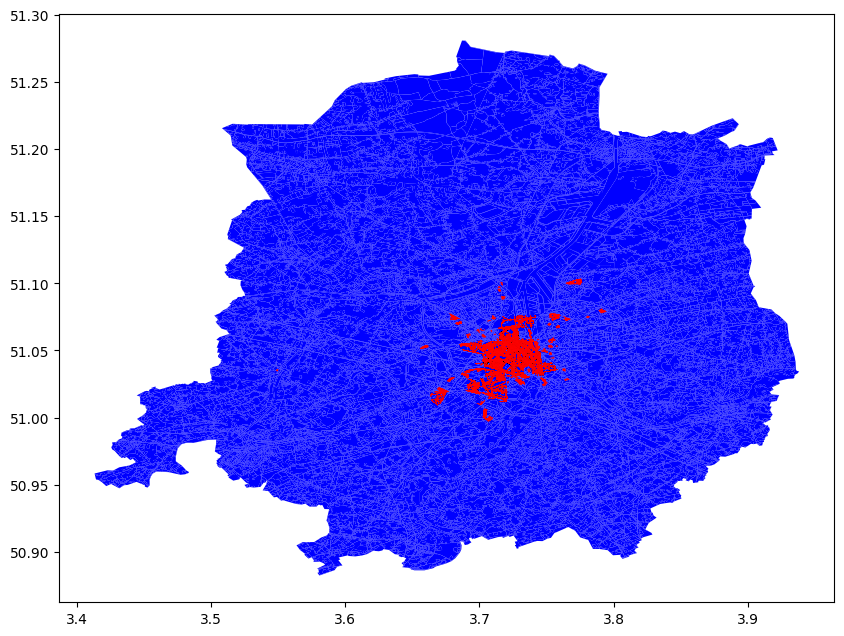

In [569]:
# Convert merged_3 DataFrame to GeoDataFrame
merged_3_gdf = gpd.GeoDataFrame(merged_3, geometry='Polygon')

# Check if each polygon from merged_3 is in gent_shapefile
merged_3_gdf['In_Gent'] = merged_3_gdf.geometry.within(gent_shapefile.unary_union)

# Spatial join to find the intersecting polygons
merged_3_gent = gpd.sjoin(merged_3_gdf, gent_shapefile, how='inner', op='intersects')

# Plot gent_shapefile with polygons from merged_3_gent in a different color
fig, ax = plt.subplots(figsize=(10, 10))
gent_shapefile.plot(ax=ax, color='blue')
merged_3_gent.plot(ax=ax, color='red')
plt.show()

#### 1.5 Scaling

In [570]:
scaler = StandardScaler()

importantData = merged_3[['Postal code', 'Main_Price_Plus_Aditional', 'Max power (kVA)', 'Estimated consumption (kWh)', 'Money spent on energy (€)', 'Storage capacity (kWh)', 'Money_spent_on_energy_(%)']]
importantData = scaler.fit_transform(importantData)

### 2. Clusters

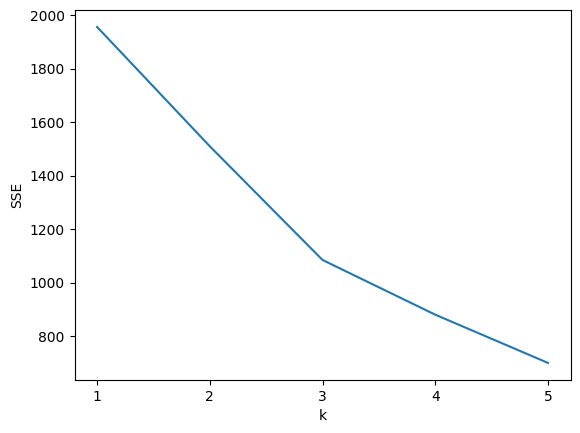

In [571]:
#To identify the best quality clusters,we'll try different numbers of clusters.

ks = range(1, 6)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(importantData)
    inertias.append(model.inertia_)

#Next, using the elbow method, we plot the inertia to see which number of clusters is the best choice.

plt.plot(ks, inertias)
plt.xlabel('k')
plt.ylabel('SSE')
plt.xticks(ks)
plt.show()

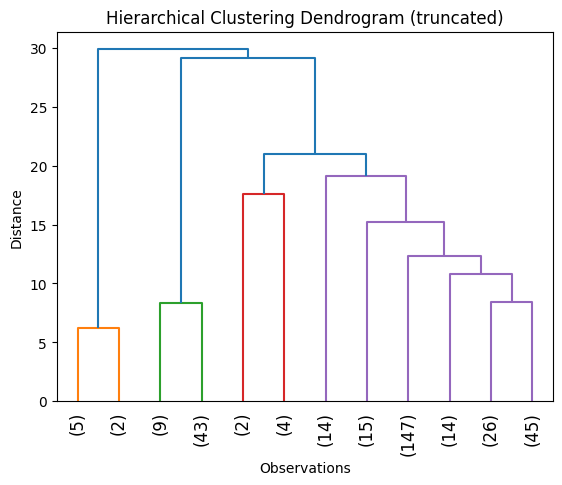

In [572]:
#Another method to identify the number of clusters is the dendogram.

hclustering = linkage(importantData, 'ward')
#hclustering = linkage(customers_perspective, 'complete')
#hclustering = linkage(customers_perspective, 'average')

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Observations')
plt.ylabel('Distance')

dendrogram(
    hclustering,
    truncate_mode='lastp',
    p=12,
    show_leaf_counts=True,
    leaf_rotation=90.,
    leaf_font_size=12.,
#show_contracted=True,
)
plt.show()

In [573]:
model = KMeans(n_clusters=3)
model.fit(importantData)
merged_3_k = merged_3.copy()
merged_3_k['label_cust'] = model.labels_
merged_3_k

,Street,Postal code,Lat,Long,Price main value,Price additional value,Year,Max power (kVA),Estimated consumption (kWh),Money spent on energy (€),Storage capacity (kWh),Inverter power (kVA),Main_Price_Plus_Aditional,Rent_Prices,Money_spent_on_energy_(%),Polygon,label_cust
0,dendermondsesteenweg,9000,51.06,3.74,1300,50.00,2020,7.16,7565693.48,3631532.87,8.78,9.29,1350.00,1296000.00,0.36,POLYGON ((3.7426977409540507 51.05648214004452...,0
1,dendermondsesteenweg,9000,51.06,3.74,1500,75.00,2020,7.16,7565693.48,3631532.87,8.78,9.29,1575.00,1512000.00,0.42,POLYGON ((3.7430155024615965 51.05393858394738...,0
2,brusselsesteenweg,9050,51.04,3.75,790,60.00,2020,4.23,9486608.34,4553572.00,8.78,9.29,850.00,816000.00,0.18,"POLYGON ((3.754146475958067 51.04044210976553,...",1
3,brugsesteenweg,9030,51.08,3.68,950,0.00,2020,4.91,7800221.36,3744106.25,8.78,9.29,950.00,912000.00,0.24,"POLYGON ((3.682723288110577 51.07490996426906,...",1
4,brugsesteenweg,9030,51.07,3.68,925,0.00,2020,4.91,7800221.36,3744106.25,8.78,9.29,925.00,888000.00,0.24,POLYGON ((3.686455842433568 51.071244593327336...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,sint-annastraat,9000,51.05,3.73,695,0.00,2020,7.16,306222.16,146986.64,8.78,9.29,695.00,667200.00,4.54,"POLYGON ((3.733970867240713 51.04443643765111,...",0
322,frederik burvenichstraat,9050,51.04,3.75,890,0.00,2020,4.23,2576875.19,1236900.09,8.78,9.29,890.00,854400.00,0.69,"POLYGON ((3.74931531586709 51.03765913659028, ...",1
323,de pintelaan,9000,51.03,3.73,675,0.00,2020,7.16,17667355.65,8480330.71,8.78,9.29,675.00,648000.00,0.08,"POLYGON ((3.7281845508082028 51.0286308814787,...",0
324,maurits sabbestraat,9050,51.04,3.75,875,0.00,2020,4.23,559198.21,268415.14,8.78,9.29,875.00,840000.00,3.13,"POLYGON ((3.754146475958067 51.04044210976553,...",1


In [574]:
merged_3_k.rename(columns={'Postal code': 'Postal_code'}, inplace=True)
merged_3_k.rename(columns={'Max power (kVA)': 'Max_power'}, inplace=True)
merged_3_k.rename(columns={'Estimated consumption (kWh)': 'Estimated_Consumption'}, inplace=True)

[[        nan -3.04438715 -1.06951299         nan         nan        -inf
  -3.44562515]
 [ 0.59019825         nan         nan         nan         nan        -inf
          nan]
 [-1.2461501  -1.46029664 -0.09265572  1.71024576  1.71024576        -inf
          nan]]


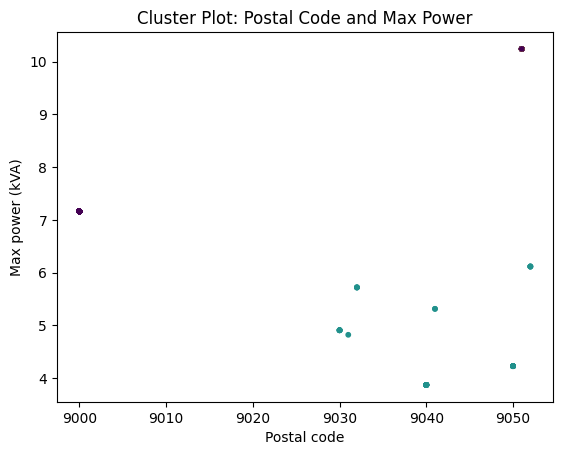

Silhouette Score: 0.7007359196004195


In [575]:
centroids = np.log(model.cluster_centers_)
print(centroids)

centroid_0_Rating = centroids[0, 0]
centroid_1_Rating = centroids[1, 0]
centroid_0_Clean = centroids[0, 1]
centroid_1_Clean = centroids[1, 1]
centroid_0_Communication = centroids[0, 2]
centroid_1_Communication = centroids[1, 2]


plt.scatter(merged_3_k.Postal_code, merged_3_k.Max_power, c=merged_3_k.label_cust, s=10)
plt.scatter(centroid_0_Rating, centroid_0_Clean, marker='X', s=100)
plt.scatter(centroid_1_Rating, centroid_1_Clean, marker='X', s=100)
plt.xlabel('Postal code')
plt.ylabel('Max power (kVA)')
plt.title('Cluster Plot: Postal Code and Max Power')

# Calculate the silhouette score
silhouette_avg = silhouette_score(merged_3_k[['Postal_code', 'Max_power']], merged_3_k['label_cust'])
silhouette_text = f"Silhouette Score: {silhouette_avg:.3f}"

plt.show()

# Add silhouette score as a text annotation

print(f"Silhouette Score: {silhouette_avg}")

### 3. Optimization Atempts -  with Gaussian Mixture Model (GMM)

In [576]:
# Convert DataFrame to numpy array
your_data =  merged_3_k
#importantData

#in order to apply the GMM we had to remove the collumn "Street" to use only numerical variables
your_data = your_data.drop('Street', axis=1)
your_data = your_data.drop('Polygon', axis=1)

X = your_data

In [577]:
X.head()

,Postal_code,Lat,Long,Price main value,Price additional value,Year,Max_power,Estimated_Consumption,Money spent on energy (€),Storage capacity (kWh),Inverter power (kVA),Main_Price_Plus_Aditional,Rent_Prices,Money_spent_on_energy_(%),label_cust
0,9000,51.06,3.74,1300,50.00,2020,7.16,7565693.48,3631532.87,8.78,9.29,1350.00,1296000.00,0.36,0
1,9000,51.06,3.74,1500,75.00,2020,7.16,7565693.48,3631532.87,8.78,9.29,1575.00,1512000.00,0.42,0
2,9050,51.04,3.75,790,60.00,2020,4.23,9486608.34,4553572.00,8.78,9.29,850.00,816000.00,0.18,1
3,9030,51.08,3.68,950,0.00,2020,4.91,7800221.36,3744106.25,8.78,9.29,950.00,912000.00,0.24,1
4,9030,51.07,3.68,925,0.00,2020,4.91,7800221.36,3744106.25,8.78,9.29,925.00,888000.00,0.24,1


In [581]:
# Assuming your DataFrame is called X
importantData = X.values

# Perform ensemble clustering
num_clusters = 3

# Initialize an array to store the cluster labels
cluster_labels = np.zeros((importantData.shape[0], num_clusters))

# Perform ensemble clustering using K-means and Gaussian Mixture Models
for i in range(num_clusters):
    # Fit K-means clustering model
    kmeans = KMeans(n_clusters=3)  # Adjust the number of clusters for K-means if needed
    kmeans.fit(importantData)
    cluster_labels[:, i] = kmeans.labels_

    # Fit Gaussian Mixture Models
    gmm = GaussianMixture(n_components=3, reg_covar=1e-6)  # Adjust the number of components and reg_covar as needed
    scaled_data = StandardScaler().fit_transform(importantData)  # Scale the data using StandardScaler
    gmm.fit(scaled_data)
    cluster_labels[:, i] = gmm.predict(scaled_data)

# Calculate the final cluster labels based on the ensemble results
final_labels = np.apply_along_axis(lambda x: np.argmax(np.bincount(x.astype(int))), axis=1, arr=cluster_labels)

# Create a copy of X
X_ensemble = X.copy()

# Add the cluster labels to the copy
X_ensemble['merged_label'] = final_labels.astype(int)

#finaldata =X_ensemble['merged_label'] = final_labels.astype(int)

# Display the updated DataFrame
#print(finaldata)

finaldata = X_ensemble.copy()
finaldata['merged_label'] = final_labels.astype(int)

# Display the updated DataFrame
print(finaldata)

# Save the updated DataFrame as a new object
new_object = finaldata.copy()

     Postal_code   Lat  Long  Price main value  Price additional value  Year  \
0           9000 51.06  3.74              1300                   50.00  2020   
1           9000 51.06  3.74              1500                   75.00  2020   
2           9050 51.04  3.75               790                   60.00  2020   
3           9030 51.08  3.68               950                    0.00  2020   
4           9030 51.07  3.68               925                    0.00  2020   
..           ...   ...   ...               ...                     ...   ...   
321         9000 51.05  3.73               695                    0.00  2020   
322         9050 51.04  3.75               890                    0.00  2020   
323         9000 51.03  3.73               675                    0.00  2020   
324         9050 51.04  3.75               875                    0.00  2020   
325         9000 51.06  3.73               750                    0.00  2020   

     Max_power  Estimated_Consumption  

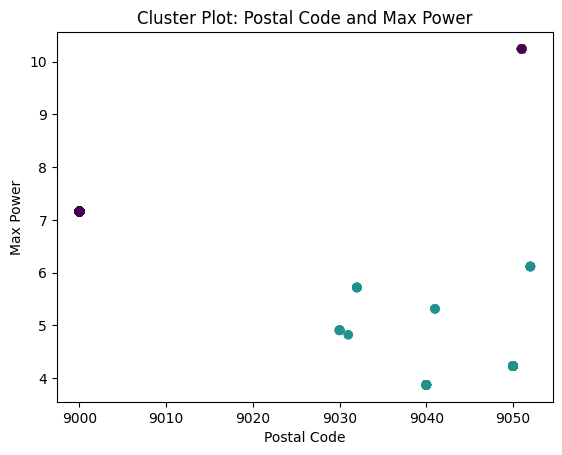

Silhouette Score: 0.07915993484452198


In [582]:

# Assuming your DataFrame is called X and has a 'merged_label' column
postal_code = new_object['Postal_code']
max_power = new_object['Max_power']
cluster_labels = new_object['label_cust']

# Create a scatter plot
plt.scatter(postal_code, max_power, c=cluster_labels)
plt.xlabel('Postal Code')
plt.ylabel('Max Power')
plt.title('Cluster Plot: Postal Code and Max Power')
plt.show()


# Calculate the silhouette score
silhouette_avg = silhouette_score(new_object, cluster_labels)  # Replace 'X' with your data and 'cluster_labels' with your actual cluster labels
silhouette_text = f"Silhouette Score: {silhouette_avg:.3f}"

print(f"Silhouette Score: {silhouette_avg}")


With this silhouette score, we can see some improvements in the clusters created. Meaning that with the same data, and the same number of clusters is possible to furthermore analyze the clusters and extract knowledge from them. With this new column, we can compare the performance between any variables and the respective clusters.

## 🖼️ Visualisations
Copy here the most important visualizations (graphs, charts, maps, images, etc). You can refer to them in the Executive Summary.

Technical note: If not all the visualisations are visible, you can still include them as an image or link - in this case please upload them to your own repository.

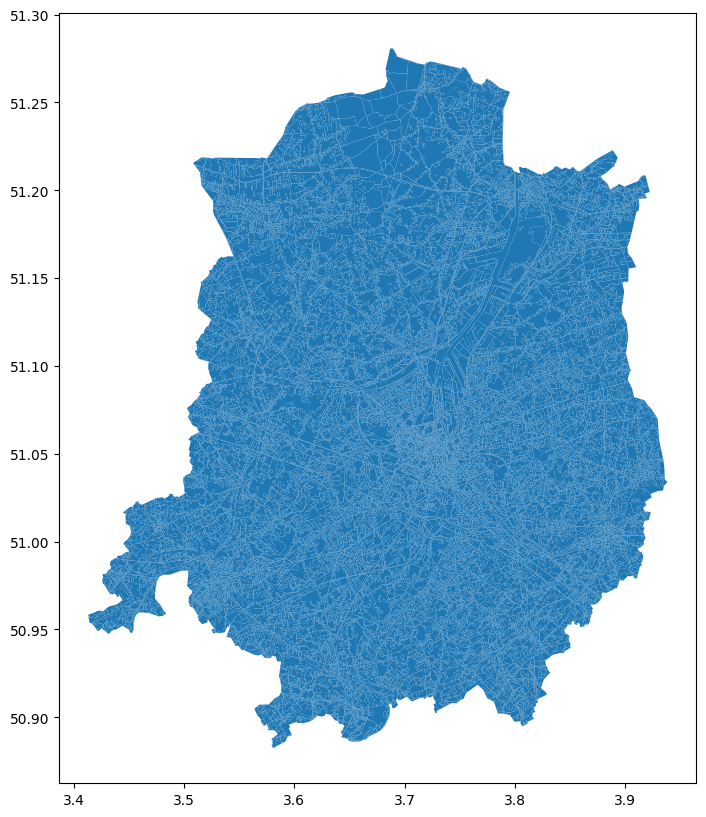

In [ ]:
# Plot the polygons from Gent
gent_shapefile.plot(figsize=(10, 10))
plt.show()

## 👓 References
List all of the external links (even if they are already linked above), such as external datasets, papers, blog posts, code repositories and any other materials.

- The external Geopandas dataset we used to build the grid of Gent with the polygons: [gent_shapefile](https://www.geo.be/catalog/details/edaf6c6e-2557-11e9-ac07-14abc58d5215?l=en)

- The source we used to determine the prices of energy consumption: [Energy Prices in Gent](https://euenergy.live/country.php?a2=BE)

**Other refrences that were also used in the report:**
- [energy.ec.europa.eu/topics/markets-and-consumers](https://energy.ec.europa.eu/topics/markets-and-consumers/energy-communities_en)

- [energy-communities-energy-saving-through-local-production-and-consumption](https://www.dexma.com/blog-en/energy-communities-energy-saving-through-local-production-and-consumption/)

- [urbanplanning](https://www.cogitatiopress.com/urbanplanning/article/view/5088/5088)

## ⏭️ Appendix
Add here any code, images or text that you still find relevant, but that was too long to include in the main report. This section is optional.
